In [1]:
!pip install --upgrade tensorflow-gpu==2.4
!pip install --upgrade tensorflow==2.4
# nvidia-driver 450.102.04
# CUDA 11.0.194
# cudnn 8.0.5

In [2]:
## conda tf2 ##
import tensorflow as tf
from tensorflow import keras # pip install keras for efn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.__version__

'2.4.0'

In [5]:
tf.keras.__version__

'2.4.0'

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
tf.test.is_built_with_gpu_support()

True

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7952558254649125913
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7332458656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2123723931155737432
physical_device_desc: "device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


1.Data 전처리

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './train/'
valid_dir = './valid/'
test_dir = './test/'

img_dagaten = ImageDataGenerator(rescale=1./255)

batch_size = 256
classes = 60

train_generator = img_dagaten.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        #color_mode="rgb",
        shuffle = True,
        class_mode='categorical',
        batch_size=batch_size,

        )

validation_generator = img_dagaten.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        #color_mode="rgb",
        shuffle = True,
        class_mode='categorical',
        batch_size=batch_size,
        )

test_generator = img_dagaten.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        #color_mode="rgb",
        shuffle = False, # True하면 밑에 뽑을때 결과 안맞음. filenames와 predict 와.
        class_mode='categorical',
        #batch_size=batch_size,
        )


Found 150000 images belonging to 60 classes.
Found 42000 images belonging to 60 classes.
Found 24000 images belonging to 60 classes.


In [11]:
# ---efficientnet 사용 ---

2. Layers

In [12]:
!pip install -U efficientnet

In [13]:
import efficientnet.keras as efn 

pre_trained_efn = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=classes)

In [14]:
# from tensorflow.keras import applications

# pre_trained_efn = tf.keras.applications.EfficientNetB0(
#     include_top=False, 
#     weights='imagenet', 
#     input_tensor=None,
#     input_shape=(224,224,3), 
#     pooling=None, 
#     classes=16,
#     # classifier_activation='softmax'
# )

In [15]:
pre_trained_efn.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [16]:
##1. try 1~4

# # Classificaion 층 추가.
# from tensorflow.keras import models
# from tensorflow.keras.layers import *
# from tensorflow.keras import initializers


# new_model = models.Sequential()

# new_model.add(pre_trained_efn)


# # 구식 0.98469
# new_model.add(Flatten())
# # 원래 256 1층
# new_model.add(Dense(256, 
#                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                     bias_initializer='zeros')) # 조절이 필요
# new_model.add(Activation('relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(16, 
#                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                     bias_initializer='zeros'))
# new_model.add(Activation('softmax'))

# # 최신기술 0.92316
# # new_model.add(tf.keras.layers.GlobalAveragePooling2D())
# # new_model.add(Dropout(0.2))
# # new_model.add(Dense(15,activation='softmax'))

# new_model.summary()
# print(new_model)
# print(type(new_model))

In [17]:
# ##2. try 5 - same to 1~4

# # Classificaion 층 추가.
# from tensorflow.keras import models
# from tensorflow.keras.layers import *
# from tensorflow.keras import initializers


# flat1 = Flatten()(pre_trained_efn.layers[-1].output)
# class1 = Dense(256, 
#                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                     bias_initializer='zeros')(flat1)

# acti1 = Activation('relu')(class1)
# drop1 = Dropout(0.5)(acti1)
# class2 = Dense(16, 
#                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                     bias_initializer='zeros')(drop1)

# predict = Activation('softmax')(class2)

# # define new model
# from keras.models import Model
# new_model = Model(inputs=pre_trained_efn.inputs, outputs=predict)

# new_model.summary()



In [18]:
# ##3. try 6

# # Classificaion 층 추가.
# from tensorflow.keras import models
# from tensorflow.keras.layers import *
# from tensorflow.keras import initializers

# top_bn = pre_trained_efn.layers[-2]
# top_acti = pre_trained_efn.layers[-1]

# GAP = GlobalAveragePooling2D()(pre_trained_efn.layers[-3].output)
# # BatchNorm=top_bn(GAP)
# # Acti=top_acti(BatchNorm)

# flat1 = Flatten()(GAP)
# class1 = Dense(256, 
#                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                     bias_initializer='zeros')(flat1)

# acti1 = Activation('relu')(class1)
# drop1 = Dropout(0.5)(acti1)
# class2 = Dense(16, 
#                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
#                    bias_initializer='zeros')(drop1)

# predict = Activation('softmax')(class2)

# # define new model
# from keras.models import Model
# new_model = Model(inputs=pre_trained_efn.inputs, outputs=predict)

# new_model.summary()



In [19]:
pre_trained_efn.trainable = False

#pre_trained_efn.trainable = False # classificaion 층만 학습

In [20]:
##3. try 7

# Classificaion 층 추가.
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras import initializers


flat1 = Flatten()(pre_trained_efn.layers[-1].output)
class1 = Dense(256, 
                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
                    bias_initializer='zeros')(flat1)

acti1 = Activation('relu')(class1)
drop1 = Dropout(0.5)(acti1)
class2 = Dense(classes, 
                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
                    bias_initializer='zeros')(drop1)

acti2 = Activation('softmax')(class2)
#probs = Dense(16, 
                    #kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
                    #bias_initializer='zeros')(acti2)


# define new model
from keras.models import Model
new_model = Model(inputs=pre_trained_efn.inputs, outputs=acti2)

new_model.summary()





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [21]:
# ##3. try 8
# new_model.add(tf.keras.layers.GlobalAveragePooling2D())
# new_model.add(Dropout(0.2))
# new_model.add(Dense(classes,activation='softmax'))







3. Train

In [22]:
from tensorflow.keras import optimizers
new_model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc']
             )



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
             EarlyStopping(monitor='val_loss', patience=10), # val_loss를 모니터링, 10번 동안 로스가 줄지 않으면 스탑 
             ModelCheckpoint(filepath='best_model_EB0_pb', ##best_model_EB0.h5'
                             monitor='val_loss', 
                             save_best_only=True) # val_loss제일 좋은 모델 저장
            ]


In [23]:
# fit_generator(object, generator, 
#     steps_per_epoch, 
#     epochs = 1,
#     verbose = getOption("keras.fit_verbose", default = 1),
#     callbacks = NULL, 
#     view_metrics = getOption("keras.view_metrics", default = "auto"), 
#     validation_data = NULL, validation_steps = NULL,
#     class_weight = NULL, 
#     max_queue_size = 10, workers = 1,
#     initial_epoch = 0)


history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=None, # 150000/256=586
    epochs=100,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=None
)



/home/user00/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
586/586 [==============================] - 788s 1s/step - loss: 3.2706 - acc: 0.3167 - val_loss: 0.1483 - val_acc: 0.9721
INFO:tensorflow:Assets written to: best_model_EB0_pb/assets
Epoch 2/100
586/586 [==============================] - 725s 1s/step - loss: 0.4926 - acc: 0.8388 - val_loss: 0.0381 - val_acc: 0.9919
INFO:tensorflow:Assets written to: best_model_EB0_pb/assets
Epoch 3/100
586/586 [==============================] - 722s 1s/step - loss: 0.2337 - acc: 0.9228 - val_loss: 0.0190 - val_acc: 0.9960
INFO:tensorflow:Assets written to: best_model_EB0_pb/assets
Epoch 4/100
586/586 [==============================] - 722s 1s/step - loss: 0.1453 - acc: 0.9523 - val_loss: 0.0118 - val_acc: 0.9971
INFO:tensorflow:Assets written to: best_model_EB0_pb/assets
Epoch 5/100
586/586 [==============================] - 722s 1s/step - loss: 0.1102 - acc: 0.9637 - val_loss: 0.0088 - val_acc: 0.9978
INFO:tensorflow:Assets written to: best_model_EB0_pb/assets
Epoch 6/100
586/586 [=========

In [49]:
# 마지막 모델 저장. best 와 별개
new_model.save('last_model_EB0_pb')

INFO:tensorflow:Assets written to: last_model_EB0_pb/assets


INFO:tensorflow:Assets written to: last_model_EB0_pb/assets


4. Result

In [50]:
hists=[]
acc = []
val_acc = []

# loss and acc
hists.append(new_model.history.history)

for i in range(len(hists)):
    acc += hists[i]["acc"] # 리스트로 변환
    val_acc += hists[i]["val_acc"]

KeyError: 'acc'

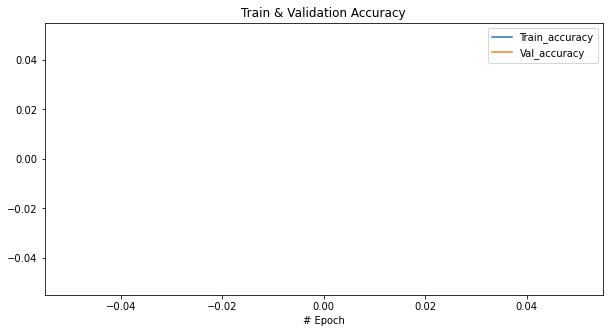

In [48]:
from datetime import datetime
# history 내 값들을 데이터프레임으로 만들고 플로팅
    
hist_df = pd.DataFrame({"# Epoch": [e for e in range(len(acc))],"Train_accuracy": acc, "Val_accuracy": val_acc})
plt.rcParams['figure.figsize'] = [10, 5]

hist_df.plot(x = "# Epoch", y = ["Train_accuracy","Val_accuracy"]) # 플로팅.
plt.title("Train & Validation Accuracy")

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H:%M:%S, from EB0")

file_name = dt_string+'_plotting.png'
plt.savefig(file_name)

plt.show()



5-1. Test (last_model)-------------------------------------------------------------------------------------------

In [ ]:
last_model = tf.keras.models.load_model('./last_model_EB0_pb')

In [27]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples, 'Samples, ', classes, 'Classes, ', int(nb_samples/classes), 'pics per Class' )

24000 Samples,  60 Classes,  400 pics per Class


In [28]:
## 테스트
# desired_batch_size=32

predict = last_model.predict_generator(test_generator) #,steps) = np.ceil(nb_samples/desired_batch_size))
test_loss, test_acc = last_model.evaluate_generator(test_generator, steps=None)
print('Test Loss :',test_loss,'Test Acc :', test_acc)

/home/user00/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/home/user00/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss : 0.0010710664791986346 Test Acc : 0.999666690826416


In [29]:
print(predict) # softmax

[[1.0000000e+00 5.3171103e-28 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0497160e-29]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 4.2774006e-24 1.9964952e-33 ... 5.0874390e-36
  1.6305987e-33 1.3315578e-24]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]]


In [30]:
print(filenames)

['00/0_15.jpg', '00/0_19.jpg', '00/0_25.jpg', '00/0_27.jpg', '00/0_29.jpg', '00/0_7.jpg', '00/0_8.jpg', '00/10_15.jpg', '00/10_29.jpg', '00/10_33.jpg', '00/11_21.jpg', '00/11_32.jpg', '00/12_11.jpg', '00/12_16.jpg', '00/12_17.jpg', '00/12_20.jpg', '00/12_26.jpg', '00/12_34.jpg', '00/12_7.jpg', '00/13_10.jpg', '00/13_2.jpg', '00/13_21.jpg', '00/13_6.jpg', '00/13_7.jpg', '00/13_9.jpg', '00/14_12.jpg', '00/14_15.jpg', '00/15_19.jpg', '00/15_24.jpg', '00/15_27.jpg', '00/15_35.jpg', '00/15_4.jpg', '00/15_7.jpg', '00/16_10.jpg', '00/16_23.jpg', '00/16_31.jpg', '00/16_34.jpg', '00/16_4.jpg', '00/17_1.jpg', '00/18_1.jpg', '00/18_10.jpg', '00/18_16.jpg', '00/18_22.jpg', '00/18_23.jpg', '00/18_25.jpg', '00/18_32.jpg', '00/19_35.jpg', '00/19_8.jpg', '00/19_9.jpg', '00/1_18.jpg', '00/1_20.jpg', '00/1_22.jpg', '00/1_23.jpg', '00/1_29.jpg', '00/20_10.jpg', '00/20_11.jpg', '00/20_12.jpg', '00/20_16.jpg', '00/20_5.jpg', '00/21_16.jpg', '00/21_17.jpg', '00/21_2.jpg', '00/21_5.jpg', '00/22_12.jpg', '00/

In [31]:
from numpy import argmax
# from scipy.special import softmax
# from sklearn.utils.extmath import softmax

li = np.zeros(classes)
wrong_list = []
low_list = []
for n,i in enumerate(predict):
    if int(filenames[n][0:2])==argmax(i):
        li[int(filenames[n][0:2])]+=1
        if 100*max(i)<95:
            low_list.append([filenames[n],argmax(i),100*max(i)])
    else:
        wrong_list.append([filenames[n], argmax(i)])

print(li/int(nb_samples/classes))
print("-"*90)

# 클래스별 확률
for n,i in enumerate(predict):
    print(filenames[n],argmax(i),100*max(i))


[1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     0.9975
 1.     1.     1.     1.     1.     1.     1.     0.9875 1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 0.9975 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     0.9975 1.     1.    ]
------------------------------------------------------------------------------------------
00/0_15.jpg 0 100.0
00/0_19.jpg 0 100.0
00/0_25.jpg 0 100.0
00/0_27.jpg 0 100.0
00/0_29.jpg 0 100.0
00/0_7.jpg 0 100.0
00/0_8.jpg 0 100.0
00/10_15.jpg 0 100.0
00/10_29.jpg 0 100.0
00/10_33.jpg 0 100.0
00/11_21.jpg 0 100.0
00/11_32.jpg 0 100.0
00/12_11.jpg 0 100.0
00/12_16.jpg 0 100.0
00/12_17.jpg 0 100.0
00/12_20.jpg 0 100.0
00/12_26.jpg 0 100.0
00/12_34.jpg 0 100.0
00/12_7.jpg 0 100.0
00/13_10.jpg 0 100.0
00/13_2.jpg 0 100.0
00/13_21.jpg 0 100.0
00/13_6.jpg 0 100.0
00/13_7.jpg 0 100.0
00/13_9

01/12_11.jpg 1 100.0
01/13_0.jpg 1 100.0
01/13_13.jpg 1 100.0
01/13_34.jpg 1 100.0
01/13_35.jpg 1 100.0
01/13_5.jpg 1 100.0
01/14_13.jpg 1 99.99865293502808
01/14_14.jpg 1 100.0
01/14_18.jpg 1 100.0
01/14_26.jpg 1 100.0
01/15_25.jpg 1 100.0
01/15_30.jpg 1 100.0
01/16_11.jpg 1 100.0
01/16_18.jpg 1 100.0
01/16_30.jpg 1 100.0
01/16_9.jpg 1 100.0
01/17_12.jpg 1 100.0
01/17_22.jpg 1 100.0
01/17_26.jpg 1 100.0
01/17_3.jpg 1 100.0
01/17_32.jpg 1 100.0
01/17_5.jpg 1 100.0
01/17_8.jpg 1 100.0
01/18_15.jpg 1 100.0
01/18_16.jpg 1 100.0
01/18_17.jpg 1 100.0
01/18_25.jpg 1 100.0
01/18_28.jpg 1 100.0
01/18_34.jpg 1 100.0
01/19_25.jpg 1 100.0
01/19_30.jpg 1 100.0
01/19_8.jpg 1 100.0
01/1_11.jpg 1 100.0
01/1_20.jpg 1 100.0
01/1_30.jpg 1 100.0
01/1_9.jpg 1 100.0
01/20_1.jpg 1 100.0
01/20_15.jpg 1 100.0
01/20_27.jpg 1 100.0
01/20_30.jpg 1 100.0
01/20_6.jpg 1 100.0
01/21_13.jpg 1 100.0
01/21_22.jpg 1 100.0
01/21_28.jpg 1 100.0
01/21_33.jpg 1 100.0
01/22_11.jpg 1 100.0
01/22_13.jpg 1 100.0
01/22_2.jpg 1 1

03/12_11.jpg 3 100.0
03/12_18.jpg 3 100.0
03/12_23.jpg 3 100.0
03/12_35.jpg 3 100.0
03/12_8.jpg 3 100.0
03/13_24.jpg 3 100.0
03/13_25.jpg 3 100.0
03/13_3.jpg 3 100.0
03/13_4.jpg 3 100.0
03/14_10.jpg 3 100.0
03/14_3.jpg 3 100.0
03/14_32.jpg 3 100.0
03/14_7.jpg 3 100.0
03/15_12.jpg 3 100.0
03/15_2.jpg 3 100.0
03/15_20.jpg 3 100.0
03/16_27.jpg 3 100.0
03/16_32.jpg 3 100.0
03/17_0.jpg 3 100.0
03/17_16.jpg 3 100.0
03/17_17.jpg 3 100.0
03/17_20.jpg 3 100.0
03/17_3.jpg 3 100.0
03/17_34.jpg 3 100.0
03/17_9.jpg 3 100.0
03/18_0.jpg 3 100.0
03/18_15.jpg 3 100.0
03/18_16.jpg 3 100.0
03/18_25.jpg 3 100.0
03/18_6.jpg 3 100.0
03/19_16.jpg 3 100.0
03/19_3.jpg 3 100.0
03/19_4.jpg 3 100.0
03/19_9.jpg 3 100.0
03/1_1.jpg 3 100.0
03/1_19.jpg 3 100.0
03/1_25.jpg 3 100.0
03/1_27.jpg 3 100.0
03/1_28.jpg 3 100.0
03/1_29.jpg 3 99.99978542327881
03/20_18.jpg 3 100.0
03/20_24.jpg 3 100.0
03/21_14.jpg 3 100.0
03/21_16.jpg 3 100.0
03/21_9.jpg 3 100.0
03/22_31.jpg 3 100.0
03/23_15.jpg 3 100.0
03/23_20.jpg 3 100.0
03

04/23_3.jpg 4 100.0
04/24_13.jpg 4 100.0
04/25_13.jpg 4 100.0
04/25_23.jpg 4 100.0
04/25_3.jpg 4 100.0
04/25_31.jpg 4 100.0
04/25_35.jpg 4 100.0
04/26_18.jpg 4 100.0
04/26_22.jpg 4 100.0
04/26_32.jpg 4 100.0
04/27_22.jpg 4 100.0
04/27_25.jpg 4 100.0
04/27_32.jpg 4 100.0
04/27_33.jpg 4 100.0
04/27_8.jpg 4 100.0
04/28_15.jpg 4 100.0
04/28_19.jpg 4 100.0
04/28_2.jpg 4 100.0
04/28_28.jpg 4 100.0
04/28_6.jpg 4 100.0
04/29_30.jpg 4 100.0
04/2_14.jpg 4 100.0
04/2_15.jpg 4 100.0
04/2_8.jpg 4 100.0
04/30_1.jpg 4 100.0
04/30_15.jpg 4 100.0
04/30_16.jpg 4 100.0
04/31_15.jpg 4 100.0
04/31_21.jpg 4 100.0
04/31_22.jpg 4 100.0
04/31_31.jpg 4 100.0
04/31_34.jpg 4 100.0
04/32_15.jpg 4 100.0
04/32_22.jpg 4 100.0
04/32_23.jpg 4 100.0
04/32_30.jpg 4 100.0
04/32_6.jpg 4 100.0
04/33_11.jpg 4 100.0
04/33_3.jpg 4 100.0
04/33_33.jpg 4 100.0
04/34_1.jpg 4 100.0
04/34_10.jpg 4 100.0
04/34_22.jpg 4 100.0
04/34_26.jpg 4 100.0
04/34_32.jpg 4 100.0
04/34_7.jpg 4 100.0
04/35_11.jpg 4 100.0
04/35_12.jpg 4 100.0
04/35_

05/99_20.jpg 5 99.41197633743286
05/99_27.jpg 5 100.0
05/99_29.jpg 5 100.0
05/99_5.jpg 5 99.99998807907104
05/9_0.jpg 5 99.99998807907104
05/9_29.jpg 5 100.0
05/9_33.jpg 5 100.0
06/0_19.jpg 6 100.0
06/0_34.jpg 6 100.0
06/10_0.jpg 6 100.0
06/10_16.jpg 6 100.0
06/10_21.jpg 6 100.0
06/11_0.jpg 6 100.0
06/11_13.jpg 6 100.0
06/11_29.jpg 6 100.0
06/11_4.jpg 6 100.0
06/11_7.jpg 6 100.0
06/12_12.jpg 6 100.0
06/12_14.jpg 6 100.0
06/12_19.jpg 6 100.0
06/12_29.jpg 6 100.0
06/12_33.jpg 6 100.0
06/12_34.jpg 6 100.0
06/13_28.jpg 6 100.0
06/13_29.jpg 6 100.0
06/13_33.jpg 6 100.0
06/14_12.jpg 6 100.0
06/14_13.jpg 6 100.0
06/14_14.jpg 6 100.0
06/14_18.jpg 6 100.0
06/14_35.jpg 6 100.0
06/15_11.jpg 6 100.0
06/15_31.jpg 6 100.0
06/16_11.jpg 6 100.0
06/16_12.jpg 6 100.0
06/16_15.jpg 6 100.0
06/16_17.jpg 6 100.0
06/16_19.jpg 6 100.0
06/16_21.jpg 6 100.0
06/16_22.jpg 6 100.0
06/16_28.jpg 6 100.0
06/17_23.jpg 6 100.0
06/17_25.jpg 6 100.0
06/18_16.jpg 6 100.0
06/18_20.jpg 6 100.0
06/18_33.jpg 6 100.0
06/19_1.j

07/21_12.jpg 7 100.0
07/21_17.jpg 7 100.0
07/21_21.jpg 7 100.0
07/21_35.jpg 7 100.0
07/21_4.jpg 7 100.0
07/22_16.jpg 7 100.0
07/22_28.jpg 7 100.0
07/22_4.jpg 7 100.0
07/23_16.jpg 7 100.0
07/23_17.jpg 7 100.0
07/23_25.jpg 7 100.0
07/23_3.jpg 7 100.0
07/24_13.jpg 7 100.0
07/24_8.jpg 7 100.0
07/25_0.jpg 7 100.0
07/25_1.jpg 7 100.0
07/25_18.jpg 7 100.0
07/25_24.jpg 7 100.0
07/25_5.jpg 7 100.0
07/26_14.jpg 7 100.0
07/26_23.jpg 7 100.0
07/26_24.jpg 7 100.0
07/26_3.jpg 7 100.0
07/26_31.jpg 7 100.0
07/26_35.jpg 7 100.0
07/27_12.jpg 7 100.0
07/27_18.jpg 7 100.0
07/27_23.jpg 7 100.0
07/27_25.jpg 7 100.0
07/27_30.jpg 7 100.0
07/27_31.jpg 7 100.0
07/27_35.jpg 7 100.0
07/27_7.jpg 7 100.0
07/28_11.jpg 7 100.0
07/28_14.jpg 7 100.0
07/28_17.jpg 7 100.0
07/28_2.jpg 7 100.0
07/28_29.jpg 7 100.0
07/29_18.jpg 7 100.0
07/29_21.jpg 7 100.0
07/29_24.jpg 7 100.0
07/29_3.jpg 7 100.0
07/29_7.jpg 7 100.0
07/2_28.jpg 7 100.0
07/30_1.jpg 7 100.0
07/30_15.jpg 7 100.0
07/30_21.jpg 7 100.0
07/30_22.jpg 7 100.0
07/30_

09/19_16.jpg 9 100.0
09/19_2.jpg 9 100.0
09/19_20.jpg 9 100.0
09/19_31.jpg 9 100.0
09/19_4.jpg 9 100.0
09/1_29.jpg 9 100.0
09/20_12.jpg 9 100.0
09/20_31.jpg 9 100.0
09/20_4.jpg 9 100.0
09/21_10.jpg 9 100.0
09/21_11.jpg 9 100.0
09/21_22.jpg 9 100.0
09/22_32.jpg 9 100.0
09/22_4.jpg 9 100.0
09/22_9.jpg 9 100.0
09/23_13.jpg 9 100.0
09/23_20.jpg 9 100.0
09/23_24.jpg 9 100.0
09/23_27.jpg 9 100.0
09/23_4.jpg 9 100.0
09/23_5.jpg 9 100.0
09/25_10.jpg 9 100.0
09/25_15.jpg 9 100.0
09/25_20.jpg 9 100.0
09/25_35.jpg 9 100.0
09/26_34.jpg 9 100.0
09/27_14.jpg 9 100.0
09/27_15.jpg 9 100.0
09/27_18.jpg 9 100.0
09/27_21.jpg 9 100.0
09/27_25.jpg 9 100.0
09/27_8.jpg 9 100.0
09/28_0.jpg 9 100.0
09/28_13.jpg 9 100.0
09/28_19.jpg 9 100.0
09/29_14.jpg 9 100.0
09/29_30.jpg 9 100.0
09/29_32.jpg 9 100.0
09/29_8.jpg 9 100.0
09/2_10.jpg 9 100.0
09/2_2.jpg 9 100.0
09/2_30.jpg 9 100.0
09/2_8.jpg 9 100.0
09/30_15.jpg 9 100.0
09/30_7.jpg 9 100.0
09/31_13.jpg 9 100.0
09/31_17.jpg 9 100.0
09/31_23.jpg 9 100.0
09/31_28.j

10/26_23.jpg 10 99.99995231628418
10/26_27.jpg 10 100.0
10/26_9.jpg 10 100.0
10/27_24.jpg 10 100.0
10/27_31.jpg 10 100.0
10/28_10.jpg 10 100.0
10/28_13.jpg 10 100.0
10/28_27.jpg 10 100.0
10/28_29.jpg 10 100.0
10/28_30.jpg 10 100.0
10/29_13.jpg 10 100.0
10/29_14.jpg 10 100.0
10/29_16.jpg 10 100.0
10/29_18.jpg 10 100.0
10/29_20.jpg 10 100.0
10/29_21.jpg 10 100.0
10/2_0.jpg 10 100.0
10/2_14.jpg 10 99.99990463256836
10/2_20.jpg 10 100.0
10/2_25.jpg 10 100.0
10/2_6.jpg 10 100.0
10/30_0.jpg 10 100.0
10/30_15.jpg 10 100.0
10/30_30.jpg 10 100.0
10/30_31.jpg 10 100.0
10/31_22.jpg 10 100.0
10/31_31.jpg 10 100.0
10/31_9.jpg 10 100.0
10/32_10.jpg 10 100.0
10/32_15.jpg 10 100.0
10/32_25.jpg 10 100.0
10/32_27.jpg 10 100.0
10/32_6.jpg 10 100.0
10/32_7.jpg 10 100.0
10/32_8.jpg 10 100.0
10/33_20.jpg 10 100.0
10/33_26.jpg 10 99.99998807907104
10/34_1.jpg 10 100.0
10/34_15.jpg 10 100.0
10/34_18.jpg 10 100.0
10/34_25.jpg 10 100.0
10/34_4.jpg 10 100.0
10/35_13.jpg 10 99.99997615814209
10/35_21.jpg 10 100.0

12/30_14.jpg 12 100.0
12/30_25.jpg 12 100.0
12/30_28.jpg 12 100.0
12/30_34.jpg 12 100.0
12/30_5.jpg 12 100.0
12/30_7.jpg 12 100.0
12/31_17.jpg 12 100.0
12/31_28.jpg 12 100.0
12/31_35.jpg 12 100.0
12/31_6.jpg 12 100.0
12/31_7.jpg 12 100.0
12/32_24.jpg 12 100.0
12/33_11.jpg 12 100.0
12/33_31.jpg 12 100.0
12/33_5.jpg 12 100.0
12/33_8.jpg 12 100.0
12/34_11.jpg 12 100.0
12/34_20.jpg 12 100.0
12/34_23.jpg 12 100.0
12/34_26.jpg 12 99.99998807907104
12/34_35.jpg 12 100.0
12/34_5.jpg 12 100.0
12/35_30.jpg 12 100.0
12/36_20.jpg 12 100.0
12/36_21.jpg 12 100.0
12/36_26.jpg 12 100.0
12/36_5.jpg 12 100.0
12/37_17.jpg 12 100.0
12/37_24.jpg 12 100.0
12/37_25.jpg 12 100.0
12/37_27.jpg 12 100.0
12/38_13.jpg 12 100.0
12/38_16.jpg 12 100.0
12/38_17.jpg 12 100.0
12/38_28.jpg 12 100.0
12/38_5.jpg 12 100.0
12/39_2.jpg 12 100.0
12/40_11.jpg 12 100.0
12/40_28.jpg 12 100.0
12/40_29.jpg 12 100.0
12/40_33.jpg 12 100.0
12/41_1.jpg 12 100.0
12/41_15.jpg 12 100.0
12/41_16.jpg 12 100.0
12/41_18.jpg 12 100.0
12/41_8.j

13/36_18.jpg 13 100.0
13/36_22.jpg 13 100.0
13/36_29.jpg 13 100.0
13/36_3.jpg 13 100.0
13/36_8.jpg 13 100.0
13/37_0.jpg 13 100.0
13/37_10.jpg 13 100.0
13/37_11.jpg 13 100.0
13/38_14.jpg 13 100.0
13/38_22.jpg 13 100.0
13/38_23.jpg 13 100.0
13/38_28.jpg 13 100.0
13/38_6.jpg 13 100.0
13/39_23.jpg 13 100.0
13/39_31.jpg 13 100.0
13/3_1.jpg 13 100.0
13/3_11.jpg 13 100.0
13/3_2.jpg 13 100.0
13/3_34.jpg 13 100.0
13/3_6.jpg 13 100.0
13/40_2.jpg 13 100.0
13/40_34.jpg 13 100.0
13/40_6.jpg 13 100.0
13/41_0.jpg 13 100.0
13/41_11.jpg 13 100.0
13/41_16.jpg 13 100.0
13/41_17.jpg 13 100.0
13/41_29.jpg 13 100.0
13/41_32.jpg 13 100.0
13/41_33.jpg 13 100.0
13/41_34.jpg 13 100.0
13/41_9.jpg 13 100.0
13/42_1.jpg 13 100.0
13/42_24.jpg 13 100.0
13/42_25.jpg 13 100.0
13/42_3.jpg 13 100.0
13/43_14.jpg 13 100.0
13/43_19.jpg 13 100.0
13/43_26.jpg 13 100.0
13/43_35.jpg 13 100.0
13/44_12.jpg 13 100.0
13/44_19.jpg 13 100.0
13/44_22.jpg 13 100.0
13/44_4.jpg 13 100.0
13/44_5.jpg 13 100.0
13/45_17.jpg 13 100.0
13/45_28

15/47_22.jpg 15 100.0
15/47_8.jpg 15 100.0
15/48_1.jpg 15 100.0
15/48_15.jpg 15 100.0
15/48_21.jpg 15 100.0
15/48_5.jpg 15 100.0
15/48_8.jpg 15 100.0
15/49_11.jpg 15 100.0
15/49_12.jpg 15 100.0
15/49_14.jpg 15 100.0
15/49_15.jpg 15 100.0
15/49_17.jpg 15 100.0
15/49_2.jpg 15 100.0
15/49_31.jpg 15 100.0
15/4_21.jpg 15 100.0
15/4_23.jpg 15 100.0
15/4_25.jpg 15 100.0
15/4_26.jpg 15 100.0
15/4_32.jpg 15 100.0
15/50_12.jpg 15 100.0
15/50_32.jpg 15 100.0
15/51_28.jpg 15 100.0
15/51_35.jpg 15 100.0
15/51_4.jpg 15 100.0
15/51_6.jpg 15 100.0
15/52_10.jpg 15 100.0
15/52_14.jpg 15 100.0
15/52_15.jpg 15 100.0
15/52_21.jpg 15 100.0
15/55_17.jpg 15 100.0
15/55_19.jpg 15 100.0
15/55_20.jpg 15 100.0
15/55_25.jpg 15 100.0
15/56_24.jpg 15 100.0
15/56_32.jpg 15 100.0
15/56_8.jpg 15 100.0
15/57_0.jpg 15 100.0
15/57_22.jpg 15 100.0
15/57_26.jpg 15 100.0
15/57_6.jpg 15 100.0
15/58_0.jpg 15 100.0
15/58_10.jpg 15 100.0
15/58_12.jpg 15 100.0
15/58_14.jpg 15 100.0
15/58_18.jpg 15 100.0
15/58_21.jpg 15 100.0
15/5

16/57_29.jpg 16 100.0
16/58_0.jpg 16 100.0
16/58_15.jpg 16 99.99998807907104
16/58_17.jpg 16 100.0
16/58_24.jpg 16 100.0
16/58_25.jpg 16 100.0
16/58_31.jpg 16 100.0
16/58_34.jpg 16 100.0
16/58_5.jpg 16 100.0
16/59_12.jpg 16 100.0
16/59_24.jpg 16 100.0
16/59_5.jpg 16 100.0
16/59_9.jpg 16 100.0
16/5_11.jpg 16 99.99896287918091
16/5_2.jpg 16 100.0
16/5_20.jpg 16 100.0
16/5_26.jpg 16 100.0
16/5_9.jpg 16 100.0
16/60_12.jpg 16 100.0
16/60_14.jpg 16 99.9991774559021
16/60_22.jpg 16 100.0
16/60_28.jpg 16 100.0
16/60_29.jpg 16 100.0
16/60_8.jpg 16 100.0
16/61_11.jpg 16 100.0
16/61_2.jpg 16 100.0
16/61_8.jpg 16 100.0
16/62_13.jpg 16 100.0
16/62_14.jpg 16 99.99998807907104
16/62_18.jpg 16 100.0
16/62_19.jpg 16 100.0
16/62_26.jpg 16 100.0
16/62_27.jpg 16 100.0
16/63_16.jpg 16 100.0
16/63_21.jpg 16 100.0
16/63_23.jpg 16 100.0
16/63_25.jpg 16 100.0
16/63_29.jpg 16 100.0
16/63_34.jpg 16 100.0
16/64_10.jpg 16 100.0
16/64_16.jpg 16 100.0
16/64_19.jpg 16 100.0
16/64_2.jpg 16 100.0
16/64_25.jpg 16 100.0


18/50_9.jpg 18 100.0
18/51_1.jpg 18 100.0
18/51_17.jpg 18 100.0
18/51_29.jpg 18 100.0
18/51_3.jpg 18 100.0
18/51_31.jpg 18 100.0
18/51_9.jpg 18 100.0
18/52_19.jpg 18 100.0
18/52_25.jpg 18 100.0
18/52_28.jpg 18 100.0
18/52_3.jpg 18 100.0
18/52_6.jpg 18 100.0
18/53_25.jpg 18 100.0
18/53_32.jpg 18 100.0
18/54_16.jpg 18 100.0
18/54_2.jpg 18 100.0
18/54_20.jpg 18 100.0
18/54_23.jpg 18 100.0
18/54_5.jpg 18 100.0
18/54_7.jpg 18 100.0
18/54_8.jpg 18 100.0
18/55_0.jpg 18 100.0
18/55_21.jpg 18 100.0
18/55_27.jpg 18 100.0
18/55_7.jpg 18 100.0
18/56_10.jpg 18 100.0
18/56_18.jpg 18 100.0
18/56_3.jpg 18 100.0
18/56_7.jpg 18 100.0
18/57_1.jpg 18 100.0
18/57_10.jpg 18 100.0
18/57_21.jpg 18 100.0
18/57_29.jpg 18 100.0
18/57_34.jpg 18 100.0
18/57_6.jpg 18 100.0
18/57_7.jpg 18 100.0
18/57_9.jpg 18 100.0
18/58_0.jpg 18 100.0
18/58_16.jpg 18 100.0
18/58_33.jpg 18 100.0
18/58_4.jpg 18 100.0
18/59_27.jpg 18 100.0
18/59_35.jpg 18 100.0
18/5_17.jpg 18 100.0
18/5_28.jpg 18 100.0
18/5_31.jpg 18 100.0
18/5_9.jpg 

19/63_32.jpg 19 100.0
19/63_7.jpg 19 100.0
19/63_9.jpg 19 100.0
19/64_13.jpg 19 100.0
19/64_22.jpg 19 100.0
19/64_24.jpg 19 100.0
19/64_26.jpg 19 100.0
19/64_27.jpg 19 100.0
19/64_28.jpg 19 100.0
19/64_29.jpg 19 100.0
19/64_8.jpg 19 100.0
19/65_21.jpg 19 100.0
19/65_28.jpg 19 100.0
19/65_35.jpg 19 100.0
19/65_6.jpg 19 100.0
19/66_1.jpg 19 100.0
19/66_15.jpg 19 100.0
19/66_27.jpg 19 100.0
19/66_29.jpg 19 100.0
19/66_4.jpg 19 100.0
19/67_13.jpg 19 99.99666213989258
19/67_19.jpg 19 99.98180270195007
19/67_35.jpg 19 100.0
19/68_15.jpg 19 99.99821186065674
19/68_30.jpg 19 100.0
19/69_13.jpg 19 100.0
19/69_18.jpg 19 100.0
19/69_24.jpg 19 100.0
19/69_28.jpg 19 100.0
19/69_29.jpg 19 100.0
19/69_33.jpg 19 100.0
19/6_11.jpg 19 100.0
19/6_19.jpg 19 100.0
19/6_35.jpg 19 100.0
19/70_13.jpg 19 100.0
19/70_23.jpg 19 100.0
19/70_28.jpg 19 100.0
19/71_0.jpg 19 100.0
19/71_1.jpg 19 100.0
19/71_10.jpg 19 99.99995231628418
19/71_3.jpg 19 100.0
19/71_7.jpg 19 100.0
19/72_14.jpg 19 99.99384880065918
19/72_2

21/68_13.jpg 21 100.0
21/68_23.jpg 21 100.0
21/68_24.jpg 21 100.0
21/68_28.jpg 21 100.0
21/68_29.jpg 21 100.0
21/68_32.jpg 21 100.0
21/68_35.jpg 21 100.0
21/69_1.jpg 21 100.0
21/69_11.jpg 21 100.0
21/69_19.jpg 21 100.0
21/69_28.jpg 21 100.0
21/69_35.jpg 21 100.0
21/6_35.jpg 21 100.0
21/70_19.jpg 21 100.0
21/70_2.jpg 21 100.0
21/70_20.jpg 21 100.0
21/70_21.jpg 21 100.0
21/70_5.jpg 21 100.0
21/70_8.jpg 21 100.0
21/71_10.jpg 21 100.0
21/71_33.jpg 21 100.0
21/71_7.jpg 21 100.0
21/72_26.jpg 21 100.0
21/72_31.jpg 21 100.0
21/73_15.jpg 21 100.0
21/73_22.jpg 21 99.99997615814209
21/73_23.jpg 21 100.0
21/73_26.jpg 21 100.0
21/73_30.jpg 21 100.0
21/73_31.jpg 21 100.0
21/73_33.jpg 21 100.0
21/73_6.jpg 21 100.0
21/74_0.jpg 21 100.0
21/74_10.jpg 21 100.0
21/74_22.jpg 21 100.0
21/74_26.jpg 21 100.0
21/74_31.jpg 21 100.0
21/74_7.jpg 21 100.0
21/75_15.jpg 21 100.0
21/75_19.jpg 21 100.0
21/75_21.jpg 21 100.0
21/75_23.jpg 21 100.0
21/75_27.jpg 21 100.0
21/75_3.jpg 21 100.0
21/75_31.jpg 21 100.0
21/75_33

22/59_3.jpg 22 100.0
22/59_35.jpg 22 100.0
22/59_9.jpg 22 100.0
22/5_14.jpg 22 100.0
22/5_15.jpg 22 100.0
22/5_27.jpg 22 100.0
22/5_29.jpg 22 100.0
22/5_30.jpg 22 100.0
22/60_20.jpg 22 100.0
22/60_22.jpg 22 100.0
22/60_29.jpg 22 100.0
22/60_32.jpg 22 100.0
22/60_33.jpg 22 100.0
22/61_9.jpg 22 100.0
22/62_19.jpg 22 100.0
22/62_26.jpg 22 100.0
22/62_9.jpg 22 100.0
22/63_0.jpg 22 100.0
22/63_19.jpg 22 100.0
22/63_25.jpg 22 100.0
22/63_9.jpg 22 100.0
22/64_30.jpg 22 100.0
22/64_33.jpg 22 100.0
22/64_5.jpg 22 100.0
22/64_8.jpg 22 100.0
22/65_13.jpg 22 100.0
22/65_27.jpg 22 100.0
22/65_31.jpg 22 100.0
22/66_2.jpg 22 100.0
22/66_27.jpg 22 100.0
22/66_9.jpg 22 100.0
22/67_12.jpg 22 100.0
22/67_18.jpg 22 100.0
22/67_20.jpg 22 100.0
22/67_22.jpg 22 100.0
22/67_33.jpg 22 100.0
22/68_24.jpg 22 100.0
22/68_3.jpg 22 100.0
22/68_8.jpg 22 100.0
22/68_9.jpg 22 100.0
22/69_15.jpg 22 100.0
22/69_34.jpg 22 100.0
22/69_7.jpg 22 100.0
22/6_1.jpg 22 100.0
22/6_17.jpg 22 100.0
22/6_20.jpg 22 100.0
22/6_34.jpg

24/64_2.jpg 24 100.0
24/64_30.jpg 24 100.0
24/64_35.jpg 24 100.0
24/65_18.jpg 24 100.0
24/65_21.jpg 24 100.0
24/65_3.jpg 24 100.0
24/66_1.jpg 24 100.0
24/66_10.jpg 24 100.0
24/66_12.jpg 24 100.0
24/66_17.jpg 24 100.0
24/66_27.jpg 24 100.0
24/66_5.jpg 24 100.0
24/66_6.jpg 24 100.0
24/67_0.jpg 24 100.0
24/67_16.jpg 24 100.0
24/67_20.jpg 24 100.0
24/67_35.jpg 24 100.0
24/67_7.jpg 24 100.0
24/67_9.jpg 24 100.0
24/68_15.jpg 24 100.0
24/68_31.jpg 24 100.0
24/69_13.jpg 24 100.0
24/69_2.jpg 24 100.0
24/69_21.jpg 24 100.0
24/69_29.jpg 24 100.0
24/69_35.jpg 24 100.0
24/6_28.jpg 24 100.0
24/6_6.jpg 24 100.0
24/6_7.jpg 24 100.0
24/70_16.jpg 24 100.0
24/71_12.jpg 24 100.0
24/71_15.jpg 24 100.0
24/71_16.jpg 24 100.0
24/71_18.jpg 24 100.0
24/71_7.jpg 24 100.0
24/72_0.jpg 24 100.0
24/72_15.jpg 24 100.0
24/72_17.jpg 24 100.0
24/72_32.jpg 24 100.0
24/72_35.jpg 24 100.0
24/73_2.jpg 24 100.0
24/73_22.jpg 24 100.0
24/73_30.jpg 24 100.0
24/73_32.jpg 24 100.0
24/73_8.jpg 24 100.0
24/74_26.jpg 24 100.0
24/74_

25/74_13.jpg 25 99.9997615814209
25/74_14.jpg 25 100.0
25/74_33.jpg 25 100.0
25/75_13.jpg 25 99.9998927116394
25/75_19.jpg 25 100.0
25/75_30.jpg 25 100.0
25/75_33.jpg 25 100.0
25/75_34.jpg 25 100.0
25/75_5.jpg 25 100.0
25/76_13.jpg 25 100.0
25/76_14.jpg 25 100.0
25/76_18.jpg 25 100.0
25/77_10.jpg 25 100.0
25/77_12.jpg 25 100.0
25/77_29.jpg 25 100.0
25/77_30.jpg 25 100.0
25/78_15.jpg 25 99.96706247329712
25/78_28.jpg 25 100.0
25/78_35.jpg 25 100.0
25/79_1.jpg 25 100.0
25/79_2.jpg 25 100.0
25/79_26.jpg 25 100.0
25/79_3.jpg 25 100.0
25/79_32.jpg 25 100.0
25/79_6.jpg 25 100.0
25/79_8.jpg 25 100.0
25/7_16.jpg 25 100.0
25/7_24.jpg 25 100.0
25/7_4.jpg 25 100.0
25/7_6.jpg 25 100.0
25/80_13.jpg 25 100.0
25/80_28.jpg 25 100.0
25/80_35.jpg 25 100.0
25/80_5.jpg 25 100.0
25/81_0.jpg 25 100.0
25/81_13.jpg 25 100.0
25/81_33.jpg 25 100.0
25/82_24.jpg 25 100.0
25/83_22.jpg 25 100.0
25/83_29.jpg 25 100.0
25/83_30.jpg 25 99.99840259552002
25/83_35.jpg 25 100.0
25/84_21.jpg 25 99.99992847442627
25/84_5.jp

27/79_11.jpg 27 100.0
27/79_21.jpg 27 100.0
27/79_24.jpg 27 100.0
27/7_12.jpg 27 99.99998807907104
27/7_33.jpg 27 100.0
27/80_11.jpg 27 100.0
27/80_32.jpg 27 99.998939037323
27/81_0.jpg 27 100.0
27/81_11.jpg 27 100.0
27/81_17.jpg 27 100.0
27/81_18.jpg 27 100.0
27/81_24.jpg 27 100.0
27/81_25.jpg 27 100.0
27/81_6.jpg 27 100.0
27/82_12.jpg 30 78.76198291778564
27/82_17.jpg 27 50.14541745185852
27/82_19.jpg 30 39.37067687511444
27/82_20.jpg 32 42.18476712703705
27/82_21.jpg 40 54.70864176750183
27/82_29.jpg 40 76.52368545532227
27/82_3.jpg 27 69.11653280258179
27/83_10.jpg 27 100.0
27/83_22.jpg 27 100.0
27/83_26.jpg 27 100.0
27/83_29.jpg 27 100.0
27/83_3.jpg 27 100.0
27/83_7.jpg 27 100.0
27/84_0.jpg 27 100.0
27/84_15.jpg 27 100.0
27/84_20.jpg 27 100.0
27/84_26.jpg 27 99.9964952468872
27/84_8.jpg 27 100.0
27/84_9.jpg 27 100.0
27/85_18.jpg 27 99.99991655349731
27/85_30.jpg 27 100.0
27/86_11.jpg 27 100.0
27/86_13.jpg 27 100.0
27/86_18.jpg 27 100.0
27/86_19.jpg 27 100.0
27/86_21.jpg 27 100.0
2

28/78_1.jpg 28 100.0
28/78_17.jpg 28 100.0
28/78_23.jpg 28 100.0
28/78_33.jpg 28 100.0
28/79_12.jpg 28 100.0
28/79_13.jpg 28 100.0
28/79_28.jpg 28 100.0
28/79_29.jpg 28 100.0
28/79_30.jpg 28 100.0
28/7_20.jpg 28 100.0
28/7_21.jpg 28 100.0
28/7_3.jpg 28 100.0
28/7_6.jpg 28 100.0
28/80_18.jpg 28 100.0
28/80_33.jpg 28 100.0
28/80_9.jpg 28 100.0
28/81_20.jpg 28 100.0
28/81_29.jpg 28 100.0
28/82_11.jpg 28 100.0
28/82_30.jpg 28 100.0
28/83_14.jpg 28 100.0
28/83_29.jpg 28 100.0
28/84_13.jpg 28 100.0
28/84_2.jpg 28 100.0
28/84_26.jpg 28 100.0
28/84_31.jpg 28 99.99667406082153
28/84_33.jpg 28 100.0
28/84_35.jpg 28 100.0
28/84_4.jpg 28 100.0
28/85_10.jpg 28 100.0
28/85_24.jpg 28 100.0
28/85_25.jpg 28 99.99998807907104
28/85_31.jpg 28 100.0
28/85_33.jpg 28 99.9998688697815
28/86_1.jpg 28 100.0
28/86_17.jpg 28 100.0
28/86_2.jpg 28 100.0
28/86_21.jpg 28 99.99988079071045
28/86_23.jpg 28 99.99996423721313
28/86_4.jpg 28 100.0
28/86_5.jpg 28 100.0
28/87_1.jpg 28 100.0
28/87_21.jpg 28 100.0
28/87_22.j

30/71_18.jpg 30 99.99995231628418
30/71_2.jpg 30 100.0
30/71_23.jpg 30 99.9998927116394
30/71_29.jpg 30 99.9998927116394
30/71_30.jpg 30 100.0
30/71_33.jpg 30 100.0
30/71_35.jpg 30 100.0
30/72_10.jpg 30 99.99998807907104
30/72_30.jpg 30 100.0
30/73_13.jpg 30 100.0
30/73_2.jpg 30 100.0
30/73_20.jpg 30 100.0
30/73_29.jpg 30 100.0
30/74_14.jpg 30 100.0
30/74_16.jpg 30 100.0
30/74_22.jpg 30 100.0
30/74_3.jpg 30 100.0
30/74_31.jpg 30 100.0
30/75_21.jpg 30 100.0
30/75_34.jpg 30 100.0
30/76_14.jpg 30 99.99997615814209
30/76_17.jpg 30 100.0
30/76_27.jpg 30 100.0
30/76_28.jpg 30 100.0
30/76_30.jpg 30 100.0
30/76_31.jpg 30 100.0
30/76_6.jpg 30 99.99996423721313
30/76_8.jpg 30 99.99995231628418
30/77_33.jpg 30 100.0
30/77_7.jpg 30 100.0
30/77_8.jpg 30 99.99438524246216
30/78_24.jpg 30 99.99998807907104
30/78_9.jpg 30 100.0
30/79_19.jpg 30 100.0
30/7_10.jpg 30 100.0
30/7_12.jpg 30 100.0
30/7_14.jpg 30 100.0
30/7_23.jpg 30 100.0
30/7_24.jpg 30 100.0
30/7_4.jpg 30 99.82960820198059
30/7_6.jpg 30 99.

31/84_21.jpg 31 100.0
31/84_29.jpg 31 100.0
31/84_30.jpg 31 100.0
31/84_4.jpg 31 100.0
31/85_21.jpg 31 99.99995231628418
31/85_30.jpg 31 100.0
31/85_6.jpg 31 100.0
31/85_7.jpg 31 100.0
31/85_8.jpg 31 100.0
31/86_0.jpg 31 100.0
31/86_3.jpg 31 100.0
31/86_31.jpg 31 100.0
31/86_4.jpg 31 100.0
31/86_6.jpg 31 100.0
31/87_15.jpg 31 100.0
31/87_26.jpg 31 100.0
31/87_3.jpg 31 100.0
31/87_32.jpg 31 100.0
31/87_33.jpg 31 100.0
31/88_12.jpg 31 100.0
31/88_21.jpg 31 100.0
31/88_27.jpg 31 100.0
31/88_29.jpg 31 100.0
31/89_24.jpg 31 100.0
31/8_23.jpg 31 100.0
31/8_34.jpg 31 100.0
31/90_10.jpg 31 100.0
31/90_13.jpg 31 100.0
31/90_27.jpg 31 100.0
31/90_30.jpg 31 100.0
31/90_34.jpg 31 100.0
31/91_1.jpg 31 100.0
31/91_11.jpg 31 99.99997615814209
31/92_24.jpg 31 100.0
31/92_29.jpg 31 100.0
31/92_32.jpg 31 100.0
31/93_10.jpg 31 100.0
31/93_17.jpg 31 99.99998807907104
31/93_2.jpg 31 100.0
31/93_23.jpg 31 100.0
31/93_25.jpg 31 100.0
31/93_33.jpg 31 100.0
31/94_22.jpg 31 99.99998807907104
31/94_25.jpg 31 99.

33/77_14.jpg 33 99.99998807907104
33/77_25.jpg 33 99.99995231628418
33/77_34.jpg 33 100.0
33/77_5.jpg 33 100.0
33/77_6.jpg 33 99.99998807907104
33/78_19.jpg 33 99.9987006187439
33/78_29.jpg 33 100.0
33/78_3.jpg 33 100.0
33/78_32.jpg 33 99.96788501739502
33/79_18.jpg 33 99.99827146530151
33/79_27.jpg 33 100.0
33/7_17.jpg 33 100.0
33/7_21.jpg 33 100.0
33/7_24.jpg 33 100.0
33/7_28.jpg 33 100.0
33/7_30.jpg 33 100.0
33/7_32.jpg 33 100.0
33/7_8.jpg 33 100.0
33/80_0.jpg 33 100.0
33/80_17.jpg 33 99.96981620788574
33/80_18.jpg 33 99.99531507492065
33/80_20.jpg 33 99.85074400901794
33/81_6.jpg 33 99.9998927116394
33/82_12.jpg 33 100.0
33/82_14.jpg 33 100.0
33/82_18.jpg 33 100.0
33/82_22.jpg 33 99.99997615814209
33/82_23.jpg 33 99.99998807907104
33/83_17.jpg 33 99.92474317550659
33/83_22.jpg 33 99.90646243095398
33/83_25.jpg 33 99.97652173042297
33/83_8.jpg 33 100.0
33/84_1.jpg 33 100.0
33/84_10.jpg 33 100.0
33/84_18.jpg 33 100.0
33/84_21.jpg 33 100.0
33/84_4.jpg 33 100.0
33/85_1.jpg 33 100.0
33/

34/84_4.jpg 34 100.0
34/84_6.jpg 34 100.0
34/84_7.jpg 34 100.0
34/85_24.jpg 34 100.0
34/86_0.jpg 34 100.0
34/86_15.jpg 34 100.0
34/86_17.jpg 34 100.0
34/86_34.jpg 34 100.0
34/86_35.jpg 34 100.0
34/86_7.jpg 34 100.0
34/87_10.jpg 34 100.0
34/87_12.jpg 34 100.0
34/87_20.jpg 34 100.0
34/87_28.jpg 34 100.0
34/87_5.jpg 34 100.0
34/88_18.jpg 34 100.0
34/88_19.jpg 34 100.0
34/88_20.jpg 34 100.0
34/88_22.jpg 34 100.0
34/88_35.jpg 34 100.0
34/88_9.jpg 34 100.0
34/89_21.jpg 34 100.0
34/8_5.jpg 34 100.0
34/8_7.jpg 34 100.0
34/90_20.jpg 34 100.0
34/90_23.jpg 34 100.0
34/90_29.jpg 34 100.0
34/90_30.jpg 34 99.99998807907104
34/90_34.jpg 34 100.0
34/90_4.jpg 34 100.0
34/90_8.jpg 34 100.0
34/91_18.jpg 34 100.0
34/91_24.jpg 34 100.0
34/91_26.jpg 34 100.0
34/91_32.jpg 34 100.0
34/91_5.jpg 34 100.0
34/92_13.jpg 34 100.0
34/92_5.jpg 34 100.0
34/93_11.jpg 34 100.0
34/93_14.jpg 34 100.0
34/93_19.jpg 34 100.0
34/93_25.jpg 34 100.0
34/93_30.jpg 34 99.99604225158691
34/94_12.jpg 34 100.0
34/94_20.jpg 34 99.9992

36/47_34.jpg 36 100.0
36/47_35.jpg 36 100.0
36/47_5.jpg 36 100.0
36/49_10.jpg 36 100.0
36/4_28.jpg 36 100.0
36/4_6.jpg 36 100.0
36/50_19.jpg 36 100.0
36/50_2.jpg 36 100.0
36/50_6.jpg 36 100.0
36/51_0.jpg 36 100.0
36/51_13.jpg 36 100.0
36/51_20.jpg 36 100.0
36/51_30.jpg 36 100.0
36/51_33.jpg 36 100.0
36/52_10.jpg 36 100.0
36/52_24.jpg 36 100.0
36/52_29.jpg 36 99.99945163726807
36/52_31.jpg 36 100.0
36/53_10.jpg 36 100.0
36/53_15.jpg 36 100.0
36/53_8.jpg 36 100.0
36/54_28.jpg 36 100.0
36/54_33.jpg 36 100.0
36/55_3.jpg 36 100.0
36/55_4.jpg 36 100.0
36/56_15.jpg 36 100.0
36/56_19.jpg 36 100.0
36/56_23.jpg 36 100.0
36/56_26.jpg 36 100.0
36/56_30.jpg 36 100.0
36/56_35.jpg 36 100.0
36/57_2.jpg 36 100.0
36/57_32.jpg 36 100.0
36/57_33.jpg 36 100.0
36/57_4.jpg 36 100.0
36/57_5.jpg 36 100.0
36/58_0.jpg 36 100.0
36/58_11.jpg 36 100.0
36/58_13.jpg 36 100.0
36/58_26.jpg 36 100.0
36/58_28.jpg 36 100.0
36/58_33.jpg 36 100.0
36/59_0.jpg 36 100.0
36/59_12.jpg 36 100.0
36/59_21.jpg 36 100.0
36/59_25.jpg 

37/65_33.jpg 37 100.0
37/65_7.jpg 37 100.0
37/66_31.jpg 37 100.0
37/67_1.jpg 37 100.0
37/67_12.jpg 37 100.0
37/67_17.jpg 37 100.0
37/67_22.jpg 37 100.0
37/67_5.jpg 37 100.0
37/68_2.jpg 37 100.0
37/68_21.jpg 37 100.0
37/68_3.jpg 37 100.0
37/69_10.jpg 37 100.0
37/69_13.jpg 37 100.0
37/69_27.jpg 37 100.0
37/69_32.jpg 37 100.0
37/69_8.jpg 37 100.0
37/69_9.jpg 37 100.0
37/6_25.jpg 37 100.0
37/70_26.jpg 37 100.0
37/71_2.jpg 37 100.0
37/72_24.jpg 37 100.0
37/72_34.jpg 37 100.0
37/72_7.jpg 37 100.0
37/72_9.jpg 37 100.0
37/73_0.jpg 37 100.0
37/73_24.jpg 37 100.0
37/74_23.jpg 37 100.0
37/74_26.jpg 37 100.0
37/74_6.jpg 37 100.0
37/75_21.jpg 37 100.0
37/75_4.jpg 37 100.0
37/75_7.jpg 37 100.0
37/76_14.jpg 37 100.0
37/76_18.jpg 37 100.0
37/76_23.jpg 37 100.0
37/77_11.jpg 37 100.0
37/77_20.jpg 37 100.0
37/77_29.jpg 37 100.0
37/77_34.jpg 37 100.0
37/77_4.jpg 37 100.0
37/78_9.jpg 37 100.0
37/79_14.jpg 37 100.0
37/79_16.jpg 37 100.0
37/79_27.jpg 37 100.0
37/79_31.jpg 37 100.0
37/79_32.jpg 37 100.0
37/79

39/62_6.jpg 39 100.0
39/63_25.jpg 39 100.0
39/63_6.jpg 39 100.0
39/64_1.jpg 39 100.0
39/64_14.jpg 39 100.0
39/64_20.jpg 39 100.0
39/64_27.jpg 39 100.0
39/64_3.jpg 39 100.0
39/64_34.jpg 39 99.96058344841003
39/64_5.jpg 39 99.99840259552002
39/65_14.jpg 39 100.0
39/65_20.jpg 39 100.0
39/66_14.jpg 39 100.0
39/66_17.jpg 39 100.0
39/66_22.jpg 39 100.0
39/66_32.jpg 39 100.0
39/66_6.jpg 39 100.0
39/66_7.jpg 39 100.0
39/67_12.jpg 39 100.0
39/67_23.jpg 39 100.0
39/67_26.jpg 39 100.0
39/67_32.jpg 39 99.99909400939941
39/68_34.jpg 39 100.0
39/69_12.jpg 39 100.0
39/69_19.jpg 39 99.99997615814209
39/69_21.jpg 39 99.99998807907104
39/69_22.jpg 39 100.0
39/69_6.jpg 39 100.0
39/69_7.jpg 39 99.99998807907104
39/6_1.jpg 39 100.0
39/6_18.jpg 39 100.0
39/6_22.jpg 39 100.0
39/70_10.jpg 39 99.99998807907104
39/70_30.jpg 39 100.0
39/70_33.jpg 39 99.99998807907104
39/70_6.jpg 39 100.0
39/71_21.jpg 39 99.99998807907104
39/71_4.jpg 39 100.0
39/72_1.jpg 39 100.0
39/72_16.jpg 39 100.0
39/72_18.jpg 39 100.0
39/72_

40/50_18.jpg 40 100.0
40/50_22.jpg 40 100.0
40/50_4.jpg 40 100.0
40/51_2.jpg 40 100.0
40/51_22.jpg 40 100.0
40/51_23.jpg 40 100.0
40/51_28.jpg 40 100.0
40/52_19.jpg 40 99.99994039535522
40/52_24.jpg 40 99.39765930175781
40/52_3.jpg 40 100.0
40/52_4.jpg 40 100.0
40/52_5.jpg 40 100.0
40/53_17.jpg 40 100.0
40/53_25.jpg 40 100.0
40/53_26.jpg 40 100.0
40/53_9.jpg 40 100.0
40/54_1.jpg 40 100.0
40/54_11.jpg 40 100.0
40/54_30.jpg 40 100.0
40/54_31.jpg 40 100.0
40/54_34.jpg 40 100.0
40/54_4.jpg 40 100.0
40/54_7.jpg 40 100.0
40/55_11.jpg 40 99.98551607131958
40/55_13.jpg 40 99.99645948410034
40/55_25.jpg 40 99.99991655349731
40/55_26.jpg 40 99.99998807907104
40/55_31.jpg 40 100.0
40/55_32.jpg 40 99.98667240142822
40/55_34.jpg 40 100.0
40/56_12.jpg 40 100.0
40/56_22.jpg 40 100.0
40/56_31.jpg 40 100.0
40/57_2.jpg 40 99.99998807907104
40/57_21.jpg 40 100.0
40/57_23.jpg 40 100.0
40/57_7.jpg 40 100.0
40/58_2.jpg 40 100.0
40/58_28.jpg 40 100.0
40/58_6.jpg 40 100.0
40/59_22.jpg 40 100.0
40/59_4.jpg 40 

41/94_5.jpg 41 100.0
41/94_7.jpg 41 100.0
41/94_9.jpg 41 100.0
41/95_17.jpg 41 100.0
41/95_18.jpg 41 100.0
41/96_11.jpg 41 100.0
41/96_21.jpg 41 100.0
41/97_25.jpg 41 100.0
41/97_3.jpg 41 100.0
41/98_11.jpg 41 100.0
41/98_21.jpg 41 100.0
41/98_23.jpg 41 100.0
41/98_30.jpg 41 100.0
41/98_9.jpg 41 100.0
41/99_22.jpg 41 100.0
41/99_27.jpg 41 100.0
41/99_33.jpg 41 99.99994039535522
41/9_13.jpg 41 100.0
42/0_22.jpg 42 100.0
42/0_28.jpg 42 100.0
42/0_9.jpg 42 100.0
42/10_0.jpg 42 100.0
42/10_11.jpg 42 100.0
42/10_21.jpg 42 100.0
42/10_5.jpg 42 100.0
42/10_6.jpg 42 100.0
42/11_13.jpg 42 100.0
42/11_15.jpg 42 100.0
42/11_16.jpg 42 100.0
42/11_26.jpg 42 100.0
42/11_29.jpg 42 100.0
42/11_34.jpg 42 100.0
42/11_4.jpg 42 100.0
42/11_5.jpg 42 100.0
42/11_7.jpg 42 100.0
42/11_8.jpg 42 100.0
42/12_12.jpg 42 100.0
42/12_14.jpg 42 100.0
42/12_16.jpg 42 100.0
42/12_29.jpg 42 100.0
42/12_6.jpg 42 100.0
42/13_11.jpg 42 100.0
42/13_19.jpg 42 100.0
42/14_13.jpg 42 100.0
42/14_15.jpg 42 100.0
42/14_16.jpg 42 

43/12_35.jpg 43 100.0
43/12_4.jpg 43 100.0
43/13_1.jpg 43 100.0
43/13_16.jpg 43 100.0
43/13_5.jpg 43 100.0
43/13_6.jpg 43 100.0
43/14_16.jpg 43 100.0
43/14_35.jpg 43 100.0
43/14_7.jpg 43 100.0
43/15_10.jpg 43 100.0
43/15_12.jpg 43 100.0
43/15_16.jpg 43 100.0
43/15_22.jpg 43 100.0
43/15_28.jpg 43 100.0
43/16_20.jpg 43 100.0
43/16_21.jpg 43 100.0
43/16_31.jpg 43 100.0
43/16_34.jpg 43 100.0
43/16_6.jpg 43 100.0
43/17_0.jpg 43 100.0
43/17_12.jpg 43 100.0
43/17_13.jpg 43 100.0
43/17_18.jpg 43 100.0
43/18_1.jpg 43 100.0
43/18_11.jpg 43 100.0
43/18_17.jpg 43 100.0
43/18_18.jpg 43 100.0
43/18_19.jpg 43 100.0
43/18_22.jpg 43 100.0
43/18_27.jpg 43 100.0
43/18_8.jpg 43 100.0
43/19_10.jpg 43 100.0
43/19_11.jpg 43 100.0
43/19_18.jpg 43 100.0
43/1_2.jpg 43 100.0
43/1_28.jpg 43 100.0
43/1_4.jpg 43 100.0
43/1_6.jpg 43 100.0
43/1_9.jpg 43 100.0
43/20_23.jpg 43 100.0
43/20_26.jpg 43 100.0
43/21_10.jpg 43 100.0
43/21_13.jpg 43 100.0
43/21_28.jpg 43 100.0
43/21_7.jpg 43 100.0
43/22_17.jpg 43 100.0
43/22_2

44/98_31.jpg 44 100.0
44/98_7.jpg 44 100.0
44/99_16.jpg 44 100.0
44/99_17.jpg 44 100.0
44/99_2.jpg 44 100.0
44/99_21.jpg 44 100.0
44/99_31.jpg 44 100.0
44/99_5.jpg 44 100.0
44/99_9.jpg 44 100.0
44/9_17.jpg 44 100.0
44/9_31.jpg 44 100.0
44/9_34.jpg 44 100.0
44/9_35.jpg 44 100.0
45/0_11.jpg 45 100.0
45/0_13.jpg 45 100.0
45/0_19.jpg 45 100.0
45/0_25.jpg 45 100.0
45/0_27.jpg 45 100.0
45/0_7.jpg 45 99.99734163284302
45/10_21.jpg 45 99.99951124191284
45/10_9.jpg 45 100.0
45/11_21.jpg 45 99.99754428863525
45/12_12.jpg 45 100.0
45/12_18.jpg 45 99.99994039535522
45/12_20.jpg 45 100.0
45/12_28.jpg 45 100.0
45/12_30.jpg 45 100.0
45/13_11.jpg 45 99.95614886283875
45/13_4.jpg 45 100.0
45/13_7.jpg 45 99.99723434448242
45/14_21.jpg 45 100.0
45/14_23.jpg 45 100.0
45/14_24.jpg 45 100.0
45/14_30.jpg 45 100.0
45/14_4.jpg 45 100.0
45/15_1.jpg 45 100.0
45/15_13.jpg 45 99.99995231628418
45/15_22.jpg 45 99.52089190483093
45/15_24.jpg 45 99.99984502792358
45/15_25.jpg 45 99.97230172157288
45/15_27.jpg 45 99.9

45/85_11.jpg 45 99.99966621398926
45/85_12.jpg 45 99.99990463256836
45/85_18.jpg 45 99.97972846031189
45/85_26.jpg 45 100.0
45/87_11.jpg 45 100.0
45/87_20.jpg 45 100.0
45/87_23.jpg 45 100.0
45/87_32.jpg 45 100.0
45/87_7.jpg 45 99.99998807907104
45/87_8.jpg 45 99.99209642410278
45/88_11.jpg 45 100.0
45/88_13.jpg 45 100.0
45/88_24.jpg 45 99.99736547470093
45/88_30.jpg 45 100.0
45/88_31.jpg 45 100.0
45/88_8.jpg 45 100.0
45/89_10.jpg 45 100.0
45/89_24.jpg 45 99.99920129776001
45/8_16.jpg 45 100.0
45/8_2.jpg 45 100.0
45/90_10.jpg 45 99.99884366989136
45/90_18.jpg 45 99.90856647491455
45/90_7.jpg 45 100.0
45/90_8.jpg 45 99.99997615814209
45/91_12.jpg 45 99.99871253967285
45/91_16.jpg 45 100.0
45/91_19.jpg 45 100.0
45/91_26.jpg 45 100.0
45/91_29.jpg 45 100.0
45/91_9.jpg 45 99.99998807907104
45/92_21.jpg 45 97.29180932044983
45/92_28.jpg 45 95.61913013458252
45/92_7.jpg 45 100.0
45/93_1.jpg 45 100.0
45/93_5.jpg 45 100.0
45/93_9.jpg 45 100.0
45/94_34.jpg 45 100.0
45/95_10.jpg 45 100.0
45/95_11.

48/26_27.jpg 48 100.0
48/26_9.jpg 48 100.0
48/27_0.jpg 48 100.0
48/27_11.jpg 48 100.0
48/27_18.jpg 48 100.0
48/27_34.jpg 48 100.0
48/27_6.jpg 48 100.0
48/29_0.jpg 48 100.0
48/29_15.jpg 48 100.0
48/29_26.jpg 48 100.0
48/29_28.jpg 48 100.0
48/29_31.jpg 48 100.0
48/2_16.jpg 48 100.0
48/2_4.jpg 48 100.0
48/2_5.jpg 48 100.0
48/2_7.jpg 48 100.0
48/30_10.jpg 48 100.0
48/30_14.jpg 48 100.0
48/30_26.jpg 48 100.0
48/30_27.jpg 48 100.0
48/30_29.jpg 48 100.0
48/30_3.jpg 48 100.0
48/30_33.jpg 48 100.0
48/30_34.jpg 48 100.0
48/31_0.jpg 48 100.0
48/31_10.jpg 48 100.0
48/31_14.jpg 48 100.0
48/31_16.jpg 48 100.0
48/31_17.jpg 48 100.0
48/31_25.jpg 48 100.0
48/32_10.jpg 48 100.0
48/32_22.jpg 48 100.0
48/32_24.jpg 48 100.0
48/32_34.jpg 48 100.0
48/32_35.jpg 48 100.0
48/32_5.jpg 48 100.0
48/33_12.jpg 48 100.0
48/33_17.jpg 48 100.0
48/33_18.jpg 48 100.0
48/33_19.jpg 48 100.0
48/33_21.jpg 48 99.99998807907104
48/33_33.jpg 48 100.0
48/33_35.jpg 48 100.0
48/33_6.jpg 48 100.0
48/34_2.jpg 48 100.0
48/34_30.jpg 4

49/36_34.jpg 49 100.0
49/36_5.jpg 49 100.0
49/37_11.jpg 49 99.99836683273315
49/37_14.jpg 49 100.0
49/37_21.jpg 49 100.0
49/37_34.jpg 49 100.0
49/37_7.jpg 49 100.0
49/38_12.jpg 49 100.0
49/38_17.jpg 49 100.0
49/38_19.jpg 49 100.0
49/38_2.jpg 49 100.0
49/38_22.jpg 49 100.0
49/38_28.jpg 49 100.0
49/38_33.jpg 49 100.0
49/38_9.jpg 49 100.0
49/39_15.jpg 49 100.0
49/39_22.jpg 49 99.99994039535522
49/39_7.jpg 49 100.0
49/3_0.jpg 49 100.0
49/3_12.jpg 49 100.0
49/3_26.jpg 49 100.0
49/40_12.jpg 49 100.0
49/40_15.jpg 49 100.0
49/40_19.jpg 49 100.0
49/40_20.jpg 49 100.0
49/40_22.jpg 49 100.0
49/40_25.jpg 49 100.0
49/40_6.jpg 49 100.0
49/41_26.jpg 49 99.99159574508667
49/41_9.jpg 49 100.0
49/42_1.jpg 49 100.0
49/42_25.jpg 49 100.0
49/42_32.jpg 49 100.0
49/42_6.jpg 49 100.0
49/42_8.jpg 49 100.0
49/43_2.jpg 49 100.0
49/43_7.jpg 49 100.0
49/44_12.jpg 49 100.0
49/44_20.jpg 49 99.99998807907104
49/44_25.jpg 49 100.0
49/44_3.jpg 49 100.0
49/44_32.jpg 49 100.0
49/45_30.jpg 49 100.0
49/45_31.jpg 49 100.0
4

51/27_10.jpg 51 100.0
51/27_3.jpg 51 100.0
51/27_33.jpg 51 100.0
51/27_5.jpg 51 100.0
51/28_0.jpg 51 100.0
51/28_1.jpg 51 100.0
51/28_15.jpg 51 100.0
51/28_29.jpg 51 100.0
51/29_11.jpg 51 100.0
51/29_13.jpg 51 100.0
51/29_3.jpg 51 100.0
51/29_34.jpg 51 100.0
51/29_35.jpg 51 100.0
51/29_4.jpg 51 100.0
51/29_9.jpg 51 100.0
51/2_19.jpg 51 100.0
51/2_2.jpg 51 100.0
51/30_19.jpg 51 99.97982382774353
51/30_25.jpg 51 100.0
51/30_3.jpg 51 100.0
51/30_32.jpg 51 100.0
51/31_22.jpg 51 100.0
51/31_25.jpg 51 100.0
51/31_29.jpg 51 100.0
51/31_8.jpg 51 100.0
51/31_9.jpg 51 100.0
51/32_20.jpg 51 100.0
51/32_34.jpg 51 100.0
51/33_29.jpg 51 100.0
51/33_3.jpg 51 100.0
51/33_6.jpg 51 100.0
51/34_22.jpg 51 100.0
51/34_25.jpg 51 100.0
51/34_30.jpg 51 100.0
51/35_13.jpg 51 100.0
51/36_19.jpg 51 100.0
51/36_24.jpg 51 100.0
51/36_29.jpg 51 100.0
51/37_10.jpg 51 100.0
51/37_26.jpg 51 100.0
51/37_28.jpg 51 100.0
51/37_3.jpg 51 100.0
51/37_33.jpg 51 100.0
51/37_7.jpg 51 100.0
51/38_11.jpg 51 99.99994039535522
51/

52/42_27.jpg 52 100.0
52/42_30.jpg 52 100.0
52/42_6.jpg 52 100.0
52/42_8.jpg 52 100.0
52/43_22.jpg 52 100.0
52/43_26.jpg 52 100.0
52/43_31.jpg 52 100.0
52/43_33.jpg 52 100.0
52/43_34.jpg 52 100.0
52/44_33.jpg 52 100.0
52/44_35.jpg 52 100.0
52/45_1.jpg 52 100.0
52/45_27.jpg 52 100.0
52/45_4.jpg 52 100.0
52/46_26.jpg 52 100.0
52/46_3.jpg 52 100.0
52/46_34.jpg 52 100.0
52/47_22.jpg 52 100.0
52/47_31.jpg 52 100.0
52/47_4.jpg 52 100.0
52/48_0.jpg 52 100.0
52/48_18.jpg 52 100.0
52/48_30.jpg 52 100.0
52/49_16.jpg 52 100.0
52/49_17.jpg 52 100.0
52/49_31.jpg 52 100.0
52/49_4.jpg 52 100.0
52/49_5.jpg 52 100.0
52/49_8.jpg 52 100.0
52/4_11.jpg 52 100.0
52/4_14.jpg 52 100.0
52/50_30.jpg 52 100.0
52/50_31.jpg 52 100.0
52/50_34.jpg 52 100.0
52/50_5.jpg 52 100.0
52/51_11.jpg 52 100.0
52/51_16.jpg 52 100.0
52/51_25.jpg 52 100.0
52/51_29.jpg 52 100.0
52/51_6.jpg 52 100.0
52/52_21.jpg 52 100.0
52/52_25.jpg 52 100.0
52/52_3.jpg 52 100.0
52/52_33.jpg 52 100.0
52/52_34.jpg 52 100.0
52/52_7.jpg 52 100.0
52/5

54/38_33.jpg 54 99.99997615814209
54/39_14.jpg 54 100.0
54/39_34.jpg 54 100.0
54/39_7.jpg 54 100.0
54/39_9.jpg 54 100.0
54/3_1.jpg 54 100.0
54/3_2.jpg 54 99.99969005584717
54/3_25.jpg 54 100.0
54/3_29.jpg 54 100.0
54/3_30.jpg 54 99.99998807907104
54/3_33.jpg 54 99.90260601043701
54/3_7.jpg 54 100.0
54/40_14.jpg 54 100.0
54/40_21.jpg 54 100.0
54/40_22.jpg 54 99.99995231628418
54/40_26.jpg 54 100.0
54/41_1.jpg 54 100.0
54/41_24.jpg 54 100.0
54/41_33.jpg 54 100.0
54/42_1.jpg 54 100.0
54/42_11.jpg 54 100.0
54/42_13.jpg 54 100.0
54/43_16.jpg 54 100.0
54/43_18.jpg 54 100.0
54/43_33.jpg 54 100.0
54/44_16.jpg 54 99.99938011169434
54/44_31.jpg 54 99.98986721038818
54/44_34.jpg 54 99.99991655349731
54/45_11.jpg 54 100.0
54/45_21.jpg 54 100.0
54/45_25.jpg 54 99.99916553497314
54/45_5.jpg 54 100.0
54/46_16.jpg 54 100.0
54/46_5.jpg 54 100.0
54/46_8.jpg 54 99.99996423721313
54/47_23.jpg 54 100.0
54/47_32.jpg 54 100.0
54/47_4.jpg 54 100.0
54/47_5.jpg 54 100.0
54/48_0.jpg 54 100.0
54/48_15.jpg 54 100.

55/49_6.jpg 55 100.0
55/4_16.jpg 55 100.0
55/4_20.jpg 55 100.0
55/4_23.jpg 55 100.0
55/4_8.jpg 55 100.0
55/4_9.jpg 55 100.0
55/50_0.jpg 55 100.0
55/50_1.jpg 55 100.0
55/50_15.jpg 55 100.0
55/50_4.jpg 55 100.0
55/50_7.jpg 55 100.0
55/51_14.jpg 55 100.0
55/51_17.jpg 55 100.0
55/52_11.jpg 55 100.0
55/52_17.jpg 55 100.0
55/52_23.jpg 55 100.0
55/53_0.jpg 55 100.0
55/53_23.jpg 55 100.0
55/53_26.jpg 55 100.0
55/53_30.jpg 55 100.0
55/54_14.jpg 55 100.0
55/54_28.jpg 55 100.0
55/54_3.jpg 55 100.0
55/54_33.jpg 55 100.0
55/54_6.jpg 55 100.0
55/55_10.jpg 55 100.0
55/55_27.jpg 55 100.0
55/55_28.jpg 55 100.0
55/55_35.jpg 55 100.0
55/55_5.jpg 55 100.0
55/56_10.jpg 55 100.0
55/56_16.jpg 55 100.0
55/57_0.jpg 55 100.0
55/57_28.jpg 55 100.0
55/57_4.jpg 55 100.0
55/58_10.jpg 55 100.0
55/58_18.jpg 55 100.0
55/58_29.jpg 55 100.0
55/58_3.jpg 55 100.0
55/59_30.jpg 55 100.0
55/5_1.jpg 55 100.0
55/5_14.jpg 55 100.0
55/5_2.jpg 55 100.0
55/5_30.jpg 55 100.0
55/5_33.jpg 55 100.0
55/5_5.jpg 55 100.0
55/5_7.jpg 55 10

57/44_5.jpg 57 99.99997615814209
57/45_28.jpg 57 100.0
57/45_6.jpg 57 100.0
57/46_1.jpg 57 100.0
57/46_12.jpg 57 100.0
57/46_14.jpg 57 100.0
57/46_19.jpg 57 100.0
57/46_30.jpg 57 99.99998807907104
57/46_6.jpg 57 99.99995231628418
57/47_12.jpg 57 99.99998807907104
57/47_2.jpg 57 100.0
57/47_35.jpg 57 100.0
57/48_16.jpg 57 100.0
57/48_26.jpg 57 100.0
57/48_3.jpg 57 100.0
57/49_13.jpg 57 99.99996423721313
57/49_19.jpg 57 100.0
57/49_6.jpg 57 100.0
57/4_27.jpg 57 99.99971389770508
57/50_10.jpg 57 99.99997615814209
57/50_15.jpg 57 100.0
57/50_20.jpg 57 99.99992847442627
57/50_3.jpg 57 100.0
57/51_1.jpg 57 100.0
57/51_14.jpg 57 99.99959468841553
57/51_19.jpg 57 100.0
57/51_23.jpg 57 100.0
57/51_24.jpg 57 100.0
57/51_26.jpg 57 100.0
57/52_0.jpg 57 100.0
57/52_7.jpg 57 100.0
57/53_28.jpg 57 100.0
57/53_4.jpg 57 100.0
57/54_13.jpg 57 99.99985694885254
57/54_16.jpg 57 100.0
57/54_30.jpg 57 99.99971389770508
57/54_33.jpg 57 100.0
57/54_6.jpg 57 100.0
57/55_25.jpg 57 99.99819993972778
57/55_26.jpg

58/25_8.jpg 58 100.0
58/25_9.jpg 58 100.0
58/26_16.jpg 58 100.0
58/26_18.jpg 58 100.0
58/26_21.jpg 58 100.0
58/26_26.jpg 58 100.0
58/27_0.jpg 58 100.0
58/27_25.jpg 58 100.0
58/28_17.jpg 58 100.0
58/28_2.jpg 58 100.0
58/28_21.jpg 58 100.0
58/29_10.jpg 58 100.0
58/29_18.jpg 58 99.99996423721313
58/29_29.jpg 58 100.0
58/2_0.jpg 58 100.0
58/2_11.jpg 58 100.0
58/2_14.jpg 58 100.0
58/2_22.jpg 58 100.0
58/2_32.jpg 58 100.0
58/2_33.jpg 58 100.0
58/2_5.jpg 58 100.0
58/30_0.jpg 58 100.0
58/30_13.jpg 58 100.0
58/30_2.jpg 58 100.0
58/30_4.jpg 58 100.0
58/31_1.jpg 58 100.0
58/31_13.jpg 58 99.99288320541382
58/31_2.jpg 58 100.0
58/31_24.jpg 58 100.0
58/31_28.jpg 58 100.0
58/31_30.jpg 58 100.0
58/31_31.jpg 58 100.0
58/32_0.jpg 58 100.0
58/32_15.jpg 58 100.0
58/32_29.jpg 58 100.0
58/32_33.jpg 58 100.0
58/32_6.jpg 58 100.0
58/32_9.jpg 58 100.0
58/33_12.jpg 58 100.0
58/33_2.jpg 58 100.0
58/33_26.jpg 58 100.0
58/33_8.jpg 58 100.0
58/33_9.jpg 58 100.0
58/34_12.jpg 58 100.0
58/34_31.jpg 58 100.0
58/34_7.jp

In [32]:
print("Wrong Prediction :", len(wrong_list))
print("-"*90)
for i in range(len(wrong_list)):
    print(wrong_list[i])

Wrong Prediction : 8
------------------------------------------------------------------------------------------
['19/31_12.jpg', 33]
['27/82_12.jpg', 30]
['27/82_19.jpg', 30]
['27/82_20.jpg', 32]
['27/82_21.jpg', 40]
['27/82_29.jpg', 40]
['40/8_31.jpg', 30]
['57/42_4.jpg', 19]


In [33]:
print("Correct but low Prediction (Under 95%):",len(low_list))
print("-"*90)
for i in range(len(low_list)):
    print(low_list[i])

Correct but low Prediction (Under 95): 26
------------------------------------------------------------------------------------------
['04/81_19.jpg', 4, 94.71350908279419]
['05/44_27.jpg', 5, 93.58619451522827]
['16/10_22.jpg', 16, 58.696794509887695]
['16/10_34.jpg', 16, 91.39950275421143]
['19/18_20.jpg', 19, 92.12896227836609]
['19/31_12.jpg', 33, 65.85841774940491]
['19/31_23.jpg', 19, 94.58841681480408]
['25/67_6.jpg', 25, 81.36778473854065]
['27/47_11.jpg', 27, 89.22755122184753]
['27/82_12.jpg', 30, 78.76198291778564]
['27/82_17.jpg', 27, 50.14541745185852]
['27/82_19.jpg', 30, 39.37067687511444]
['27/82_20.jpg', 32, 42.18476712703705]
['27/82_21.jpg', 40, 54.70864176750183]
['27/82_29.jpg', 40, 76.52368545532227]
['27/82_3.jpg', 27, 69.11653280258179]
['30/41_1.jpg', 30, 87.9585862159729]
['30/41_11.jpg', 30, 94.08752918243408]
['30/41_13.jpg', 30, 81.20620250701904]
['30/42_6.jpg', 30, 91.33184552192688]
['32/0_25.jpg', 32, 37.1737003326416]
['32/74_28.jpg', 32, 83.75191688537

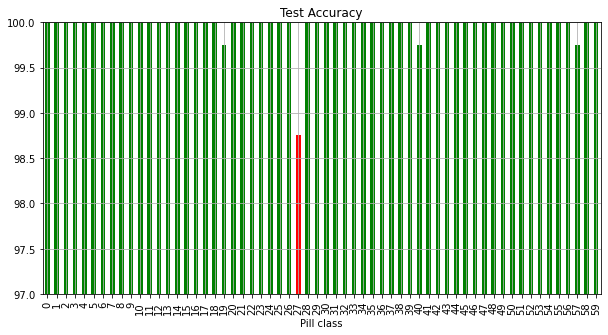

In [34]:
from datetime import datetime
test_acc=li/int(nb_samples/classes)*100
res_test = pd.DataFrame({"Pill class": [e for e in range(classes)],"Accuracy": test_acc})
a=res_test.plot.bar(grid=True, x = "Pill class", y = "Accuracy", ylim=(97,100), legend=None, color=np.where(res_test["Accuracy"]>99.5, 'g', 'r')) # 플로팅.

plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Test Accuracy")

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H:%M:%S, from EB0")

file_name = dt_string+'_test_plotting_last.png'
plt.savefig(file_name)

5-2. Test (best_model)-----------------------------------------------------------------------------------------

In [35]:
# bring best model ---------------------------------------------------------------
best_model = tf.keras.models.load_model('./best_model_EB0_pb')

In [36]:
predict = best_model.predict_generator(test_generator) #,steps) = np.ceil(nb_samples/desired_batch_size))

/home/user00/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/home/user00/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss : 0.0007814238779246807 Test Acc : 0.99979168176651


In [ ]:
test_loss, test_acc = best_model.evaluate_generator(test_generator, steps=None)
print('Test Loss :',test_loss,'Test Acc :', test_acc)

In [37]:
from numpy import argmax
# from scipy.special import softmax
# from sklearn.utils.extmath import softmax

li = np.zeros(classes)
wrong_list = []
low_list = []
for n,i in enumerate(predict):
    if int(filenames[n][0:2])==argmax(i):
        li[int(filenames[n][0:2])]+=1
        if 100*max(i)<95:
            low_list.append([filenames[n],argmax(i),100*max(i)])
    else:
        wrong_list.append([filenames[n],argmax(i),100*max(i)])

print(li/int(nb_samples/classes))
print("-"*90)

# 클래스별 확률
for n,i in enumerate(predict):
    print(filenames[n],argmax(i),100*max(i))
    

[1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     0.99   1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     0.9975 1.     1.    ]
------------------------------------------------------------------------------------------
00/0_15.jpg 0 100.0
00/0_19.jpg 0 100.0
00/0_25.jpg 0 100.0
00/0_27.jpg 0 100.0
00/0_29.jpg 0 100.0
00/0_7.jpg 0 100.0
00/0_8.jpg 0 100.0
00/10_15.jpg 0 100.0
00/10_29.jpg 0 100.0
00/10_33.jpg 0 100.0
00/11_21.jpg 0 100.0
00/11_32.jpg 0 100.0
00/12_11.jpg 0 100.0
00/12_16.jpg 0 100.0
00/12_17.jpg 0 100.0
00/12_20.jpg 0 100.0
00/12_26.jpg 0 100.0
00/12_34.jpg 0 100.0
00/12_7.jpg 0 100.0
00/13_10.jpg 0 100.0
00/13_2.jpg 0 100.0
00/13_21.jpg 0 100.0
00/13_6.jpg 0 100.0
00/13_7.jpg 0 100.0
00/13_9.jpg

03/36_0.jpg 3 100.0
03/36_22.jpg 3 100.0
03/36_27.jpg 3 100.0
03/36_3.jpg 3 100.0
03/36_33.jpg 3 100.0
03/36_35.jpg 3 100.0
03/37_1.jpg 3 100.0
03/37_11.jpg 3 100.0
03/37_12.jpg 3 100.0
03/37_13.jpg 3 100.0
03/37_19.jpg 3 100.0
03/37_27.jpg 3 100.0
03/37_29.jpg 3 100.0
03/37_3.jpg 3 100.0
03/38_31.jpg 3 100.0
03/38_6.jpg 3 100.0
03/39_15.jpg 3 100.0
03/39_16.jpg 3 100.0
03/39_21.jpg 3 100.0
03/39_26.jpg 3 100.0
03/39_27.jpg 3 100.0
03/39_30.jpg 3 100.0
03/39_32.jpg 3 100.0
03/39_4.jpg 3 100.0
03/39_5.jpg 3 100.0
03/3_17.jpg 3 100.0
03/3_2.jpg 3 100.0
03/3_22.jpg 3 100.0
03/3_35.jpg 3 100.0
03/3_5.jpg 3 100.0
03/40_14.jpg 3 100.0
03/40_2.jpg 3 100.0
03/40_24.jpg 3 100.0
03/40_31.jpg 3 100.0
03/40_32.jpg 3 100.0
03/40_34.jpg 3 100.0
03/40_4.jpg 3 100.0
03/41_10.jpg 3 100.0
03/41_12.jpg 3 100.0
03/42_1.jpg 3 100.0
03/42_19.jpg 3 100.0
03/42_2.jpg 3 100.0
03/42_20.jpg 3 100.0
03/42_23.jpg 3 100.0
03/42_27.jpg 3 100.0
03/42_5.jpg 3 100.0
03/42_8.jpg 3 100.0
03/43_17.jpg 3 100.0
03/43_21.jpg

06/37_29.jpg 6 99.99998807907104
06/37_31.jpg 6 100.0
06/38_13.jpg 6 100.0
06/38_14.jpg 6 100.0
06/38_16.jpg 6 100.0
06/38_6.jpg 6 100.0
06/39_14.jpg 6 100.0
06/39_27.jpg 6 100.0
06/39_3.jpg 6 100.0
06/39_32.jpg 6 100.0
06/39_6.jpg 6 100.0
06/3_10.jpg 6 100.0
06/3_25.jpg 6 100.0
06/40_24.jpg 6 100.0
06/41_14.jpg 6 100.0
06/41_27.jpg 6 99.99995231628418
06/42_19.jpg 6 100.0
06/42_35.jpg 6 100.0
06/42_8.jpg 6 100.0
06/42_9.jpg 6 100.0
06/43_0.jpg 6 100.0
06/43_1.jpg 6 100.0
06/43_18.jpg 6 100.0
06/43_35.jpg 6 100.0
06/43_5.jpg 6 100.0
06/44_1.jpg 6 100.0
06/44_19.jpg 6 100.0
06/44_24.jpg 6 100.0
06/45_11.jpg 6 100.0
06/45_12.jpg 6 100.0
06/45_23.jpg 6 100.0
06/45_28.jpg 6 100.0
06/45_35.jpg 6 100.0
06/45_4.jpg 6 100.0
06/46_12.jpg 6 100.0
06/46_19.jpg 6 100.0
06/46_35.jpg 6 100.0
06/46_4.jpg 6 100.0
06/47_23.jpg 6 100.0
06/47_28.jpg 6 100.0
06/47_5.jpg 6 100.0
06/48_10.jpg 6 100.0
06/48_11.jpg 6 100.0
06/49_1.jpg 6 100.0
06/49_15.jpg 6 100.0
06/49_24.jpg 6 100.0
06/49_4.jpg 6 100.0
06/4_

09/59_14.jpg 9 100.0
09/59_15.jpg 9 100.0
09/59_25.jpg 9 100.0
09/59_3.jpg 9 100.0
09/59_4.jpg 9 100.0
09/59_5.jpg 9 100.0
09/5_31.jpg 9 100.0
09/5_6.jpg 9 100.0
09/60_18.jpg 9 100.0
09/60_19.jpg 9 100.0
09/60_29.jpg 9 100.0
09/61_10.jpg 9 100.0
09/61_13.jpg 9 100.0
09/61_35.jpg 9 100.0
09/62_14.jpg 9 100.0
09/62_25.jpg 9 100.0
09/62_32.jpg 9 100.0
09/63_24.jpg 9 100.0
09/63_29.jpg 9 100.0
09/63_33.jpg 9 99.99290704727173
09/63_34.jpg 9 99.49707984924316
09/63_6.jpg 9 100.0
09/63_9.jpg 9 100.0
09/64_13.jpg 9 100.0
09/64_29.jpg 9 100.0
09/64_4.jpg 9 100.0
09/64_8.jpg 9 100.0
09/65_24.jpg 9 100.0
09/65_26.jpg 9 100.0
09/65_28.jpg 9 100.0
09/67_11.jpg 9 100.0
09/67_16.jpg 9 100.0
09/67_34.jpg 9 100.0
09/68_1.jpg 9 100.0
09/68_16.jpg 9 100.0
09/68_2.jpg 9 100.0
09/69_15.jpg 9 100.0
09/69_30.jpg 9 100.0
09/69_7.jpg 9 100.0
09/69_8.jpg 9 100.0
09/6_0.jpg 9 100.0
09/6_11.jpg 9 100.0
09/6_13.jpg 9 100.0
09/6_19.jpg 9 100.0
09/6_3.jpg 9 100.0
09/70_14.jpg 9 100.0
09/70_23.jpg 9 100.0
09/70_25.j

12/79_4.jpg 12 100.0
12/7_0.jpg 12 100.0
12/7_16.jpg 12 100.0
12/7_2.jpg 12 100.0
12/7_21.jpg 12 100.0
12/80_14.jpg 12 100.0
12/80_3.jpg 12 100.0
12/81_0.jpg 12 100.0
12/81_28.jpg 12 100.0
12/81_30.jpg 12 100.0
12/82_1.jpg 12 100.0
12/82_14.jpg 12 100.0
12/83_19.jpg 12 100.0
12/83_20.jpg 12 100.0
12/83_22.jpg 12 100.0
12/83_23.jpg 12 100.0
12/83_3.jpg 12 100.0
12/83_32.jpg 12 100.0
12/84_11.jpg 12 100.0
12/84_13.jpg 12 100.0
12/84_31.jpg 12 100.0
12/85_1.jpg 12 100.0
12/85_19.jpg 12 100.0
12/85_7.jpg 12 100.0
12/86_12.jpg 12 100.0
12/86_15.jpg 12 100.0
12/86_20.jpg 12 100.0
12/86_25.jpg 12 100.0
12/86_29.jpg 12 100.0
12/86_31.jpg 12 100.0
12/86_33.jpg 12 100.0
12/87_0.jpg 12 100.0
12/87_1.jpg 12 100.0
12/87_12.jpg 12 100.0
12/87_17.jpg 12 100.0
12/87_26.jpg 12 100.0
12/87_3.jpg 12 100.0
12/87_30.jpg 12 100.0
12/87_33.jpg 12 100.0
12/87_9.jpg 12 100.0
12/88_14.jpg 12 100.0
12/88_22.jpg 12 100.0
12/88_23.jpg 12 100.0
12/89_11.jpg 12 100.0
12/89_17.jpg 12 100.0
12/89_18.jpg 12 100.0
12/89

16/10_34.jpg 16 99.41976070404053
16/11_10.jpg 16 100.0
16/11_12.jpg 16 100.0
16/11_20.jpg 16 100.0
16/11_23.jpg 16 100.0
16/11_28.jpg 16 99.99991655349731
16/12_24.jpg 16 100.0
16/12_25.jpg 16 100.0
16/12_3.jpg 16 100.0
16/12_34.jpg 16 100.0
16/12_8.jpg 16 100.0
16/12_9.jpg 16 100.0
16/13_10.jpg 16 100.0
16/13_18.jpg 16 100.0
16/13_7.jpg 16 99.99998807907104
16/13_9.jpg 16 100.0
16/14_11.jpg 16 100.0
16/15_0.jpg 16 100.0
16/15_25.jpg 16 100.0
16/15_29.jpg 16 100.0
16/15_33.jpg 16 100.0
16/16_17.jpg 16 100.0
16/16_28.jpg 16 100.0
16/16_7.jpg 16 100.0
16/17_22.jpg 16 100.0
16/17_33.jpg 16 100.0
16/18_10.jpg 16 100.0
16/18_30.jpg 16 100.0
16/19_11.jpg 16 100.0
16/19_18.jpg 16 100.0
16/19_22.jpg 16 100.0
16/19_23.jpg 16 100.0
16/19_28.jpg 16 100.0
16/1_11.jpg 16 99.99998807907104
16/1_31.jpg 16 100.0
16/20_34.jpg 16 100.0
16/21_17.jpg 16 100.0
16/21_23.jpg 16 100.0
16/21_30.jpg 16 100.0
16/22_13.jpg 16 100.0
16/22_14.jpg 16 100.0
16/22_16.jpg 16 100.0
16/22_21.jpg 16 100.0
16/22_25.jpg 16

19/34_26.jpg 19 100.0
19/34_28.jpg 19 100.0
19/34_31.jpg 19 100.0
19/34_4.jpg 19 100.0
19/34_8.jpg 19 100.0
19/35_23.jpg 19 99.99998807907104
19/35_29.jpg 19 99.9998927116394
19/35_30.jpg 19 99.99997615814209
19/36_3.jpg 19 99.99974966049194
19/36_31.jpg 19 100.0
19/37_11.jpg 19 100.0
19/37_14.jpg 19 100.0
19/37_21.jpg 19 100.0
19/37_25.jpg 19 100.0
19/37_5.jpg 19 100.0
19/37_7.jpg 19 100.0
19/38_16.jpg 19 99.99998807907104
19/38_26.jpg 19 99.97287392616272
19/38_27.jpg 19 99.99995231628418
19/38_29.jpg 19 99.99996423721313
19/38_33.jpg 19 99.99661445617676
19/39_1.jpg 19 100.0
19/3_24.jpg 19 100.0
19/3_33.jpg 19 100.0
19/40_0.jpg 19 99.99943971633911
19/40_2.jpg 19 100.0
19/40_29.jpg 19 100.0
19/41_12.jpg 19 100.0
19/41_2.jpg 19 100.0
19/41_20.jpg 19 100.0
19/41_4.jpg 19 100.0
19/41_5.jpg 19 100.0
19/41_9.jpg 19 100.0
19/42_14.jpg 19 100.0
19/42_24.jpg 19 99.99995231628418
19/42_32.jpg 19 99.9996542930603
19/43_18.jpg 19 100.0
19/43_22.jpg 19 100.0
19/43_25.jpg 19 100.0
19/44_24.jpg 1

22/55_8.jpg 22 100.0
22/56_24.jpg 22 100.0
22/56_27.jpg 22 100.0
22/56_28.jpg 22 100.0
22/56_29.jpg 22 100.0
22/56_30.jpg 22 100.0
22/56_31.jpg 22 100.0
22/56_33.jpg 22 100.0
22/57_24.jpg 22 100.0
22/57_26.jpg 22 100.0
22/57_27.jpg 22 100.0
22/57_35.jpg 22 100.0
22/57_7.jpg 22 100.0
22/58_31.jpg 22 100.0
22/59_10.jpg 22 100.0
22/59_13.jpg 22 100.0
22/59_15.jpg 22 100.0
22/59_3.jpg 22 100.0
22/59_35.jpg 22 100.0
22/59_9.jpg 22 100.0
22/5_14.jpg 22 100.0
22/5_15.jpg 22 100.0
22/5_27.jpg 22 100.0
22/5_29.jpg 22 100.0
22/5_30.jpg 22 100.0
22/60_20.jpg 22 100.0
22/60_22.jpg 22 100.0
22/60_29.jpg 22 100.0
22/60_32.jpg 22 100.0
22/60_33.jpg 22 100.0
22/61_9.jpg 22 100.0
22/62_19.jpg 22 100.0
22/62_26.jpg 22 100.0
22/62_9.jpg 22 100.0
22/63_0.jpg 22 100.0
22/63_19.jpg 22 100.0
22/63_25.jpg 22 100.0
22/63_9.jpg 22 100.0
22/64_30.jpg 22 100.0
22/64_33.jpg 22 100.0
22/64_5.jpg 22 100.0
22/64_8.jpg 22 100.0
22/65_13.jpg 22 100.0
22/65_27.jpg 22 100.0
22/65_31.jpg 22 100.0
22/66_2.jpg 22 100.0
22/6

25/1_3.jpg 25 100.0
25/20_24.jpg 25 99.99997615814209
25/20_28.jpg 25 100.0
25/20_4.jpg 25 100.0
25/21_11.jpg 25 100.0
25/21_15.jpg 25 100.0
25/21_27.jpg 25 100.0
25/22_14.jpg 25 100.0
25/22_16.jpg 25 100.0
25/22_22.jpg 25 99.9996542930603
25/22_33.jpg 25 100.0
25/23_2.jpg 25 100.0
25/23_21.jpg 25 99.99973773956299
25/23_28.jpg 25 100.0
25/23_3.jpg 25 100.0
25/23_30.jpg 25 100.0
25/24_22.jpg 25 100.0
25/24_27.jpg 25 100.0
25/24_33.jpg 25 100.0
25/25_28.jpg 25 100.0
25/25_33.jpg 25 100.0
25/25_6.jpg 25 99.99996423721313
25/26_12.jpg 25 100.0
25/26_19.jpg 25 100.0
25/26_24.jpg 25 100.0
25/26_33.jpg 25 100.0
25/26_4.jpg 25 100.0
25/27_10.jpg 25 100.0
25/27_11.jpg 25 100.0
25/27_18.jpg 25 100.0
25/27_20.jpg 25 100.0
25/27_21.jpg 25 100.0
25/27_26.jpg 25 100.0
25/27_34.jpg 25 100.0
25/28_15.jpg 25 100.0
25/28_24.jpg 25 100.0
25/28_31.jpg 25 100.0
25/28_35.jpg 25 100.0
25/29_0.jpg 25 100.0
25/29_17.jpg 25 100.0
25/29_24.jpg 25 100.0
25/29_27.jpg 25 100.0
25/2_0.jpg 25 100.0
25/2_11.jpg 25 10

28/28_2.jpg 28 100.0
28/28_26.jpg 28 100.0
28/28_29.jpg 28 100.0
28/28_30.jpg 28 100.0
28/28_35.jpg 28 100.0
28/28_5.jpg 28 100.0
28/29_0.jpg 28 100.0
28/29_5.jpg 28 100.0
28/2_16.jpg 28 100.0
28/2_3.jpg 28 99.99979734420776
28/2_30.jpg 28 100.0
28/2_9.jpg 28 100.0
28/30_13.jpg 28 100.0
28/30_25.jpg 28 99.99984502792358
28/31_14.jpg 28 100.0
28/31_27.jpg 28 99.99998807907104
28/31_29.jpg 28 99.99998807907104
28/32_14.jpg 28 99.99998807907104
28/32_19.jpg 28 100.0
28/32_28.jpg 28 100.0
28/32_32.jpg 28 100.0
28/32_33.jpg 28 100.0
28/32_34.jpg 28 100.0
28/33_1.jpg 28 100.0
28/33_16.jpg 28 100.0
28/33_19.jpg 28 100.0
28/33_21.jpg 28 100.0
28/33_23.jpg 28 99.99998807907104
28/34_21.jpg 28 99.9998927116394
28/34_25.jpg 28 100.0
28/34_8.jpg 28 100.0
28/35_16.jpg 28 99.99996423721313
28/36_1.jpg 28 100.0
28/36_16.jpg 28 100.0
28/36_2.jpg 28 100.0
28/36_23.jpg 28 99.99998807907104
28/36_24.jpg 28 99.99994039535522
28/36_34.jpg 28 100.0
28/37_25.jpg 28 99.99994039535522
28/37_30.jpg 28 100.0
28/

31/46_28.jpg 31 100.0
31/46_32.jpg 31 100.0
31/46_35.jpg 31 100.0
31/46_8.jpg 31 100.0
31/47_17.jpg 31 100.0
31/47_27.jpg 31 99.99990463256836
31/47_33.jpg 31 100.0
31/47_5.jpg 31 99.91993308067322
31/48_1.jpg 31 100.0
31/48_21.jpg 31 99.99978542327881
31/48_32.jpg 31 99.99997615814209
31/48_9.jpg 31 100.0
31/49_30.jpg 31 100.0
31/49_7.jpg 31 100.0
31/4_2.jpg 31 100.0
31/4_20.jpg 31 100.0
31/4_24.jpg 31 100.0
31/4_34.jpg 31 100.0
31/4_9.jpg 31 100.0
31/50_20.jpg 31 99.99998807907104
31/50_22.jpg 31 99.9997615814209
31/50_31.jpg 31 100.0
31/50_6.jpg 31 100.0
31/51_0.jpg 31 99.99995231628418
31/51_22.jpg 31 100.0
31/51_25.jpg 31 100.0
31/51_35.jpg 31 100.0
31/52_19.jpg 31 100.0
31/52_20.jpg 31 99.9998688697815
31/52_23.jpg 31 100.0
31/52_26.jpg 31 100.0
31/52_6.jpg 31 100.0
31/52_8.jpg 31 100.0
31/53_13.jpg 31 100.0
31/54_30.jpg 31 100.0
31/54_5.jpg 31 100.0
31/55_20.jpg 31 100.0
31/55_30.jpg 31 100.0
31/55_31.jpg 31 100.0
31/55_32.jpg 31 100.0
31/56_10.jpg 31 100.0
31/56_16.jpg 31 100.0

34/58_20.jpg 34 100.0
34/58_30.jpg 34 100.0
34/58_35.jpg 34 100.0
34/58_6.jpg 34 100.0
34/59_10.jpg 34 100.0
34/59_19.jpg 34 100.0
34/59_28.jpg 34 100.0
34/59_35.jpg 34 100.0
34/59_9.jpg 34 100.0
34/5_13.jpg 34 100.0
34/5_9.jpg 34 100.0
34/60_14.jpg 34 100.0
34/60_20.jpg 34 100.0
34/60_23.jpg 34 100.0
34/60_25.jpg 34 100.0
34/60_31.jpg 34 100.0
34/60_6.jpg 34 100.0
34/61_16.jpg 34 100.0
34/61_23.jpg 34 100.0
34/61_33.jpg 34 100.0
34/61_4.jpg 34 100.0
34/62_12.jpg 34 100.0
34/62_16.jpg 34 100.0
34/62_22.jpg 34 100.0
34/62_29.jpg 34 100.0
34/62_35.jpg 34 100.0
34/62_6.jpg 34 100.0
34/63_32.jpg 34 100.0
34/63_34.jpg 34 99.99998807907104
34/63_6.jpg 34 100.0
34/64_19.jpg 34 100.0
34/64_27.jpg 34 100.0
34/64_28.jpg 34 100.0
34/64_30.jpg 34 100.0
34/64_8.jpg 34 100.0
34/65_14.jpg 34 100.0
34/65_16.jpg 34 100.0
34/65_17.jpg 34 100.0
34/65_2.jpg 34 100.0
34/65_34.jpg 34 100.0
34/65_6.jpg 34 100.0
34/66_11.jpg 34 100.0
34/66_17.jpg 34 100.0
34/66_19.jpg 34 99.99994039535522
34/66_21.jpg 34 99.9

37/80_21.jpg 37 100.0
37/80_26.jpg 37 100.0
37/80_32.jpg 37 100.0
37/81_33.jpg 37 100.0
37/81_5.jpg 37 100.0
37/81_7.jpg 37 100.0
37/82_12.jpg 37 100.0
37/82_21.jpg 37 100.0
37/82_24.jpg 37 100.0
37/82_27.jpg 37 100.0
37/82_30.jpg 37 100.0
37/82_32.jpg 37 100.0
37/83_1.jpg 37 100.0
37/83_11.jpg 37 100.0
37/83_19.jpg 37 100.0
37/83_29.jpg 37 100.0
37/83_35.jpg 37 100.0
37/83_6.jpg 37 100.0
37/84_12.jpg 37 100.0
37/84_13.jpg 37 100.0
37/84_22.jpg 37 100.0
37/84_29.jpg 37 100.0
37/85_0.jpg 37 100.0
37/85_28.jpg 37 100.0
37/85_30.jpg 37 100.0
37/85_31.jpg 37 100.0
37/85_32.jpg 37 100.0
37/85_4.jpg 37 100.0
37/86_14.jpg 37 100.0
37/86_15.jpg 37 100.0
37/86_20.jpg 37 100.0
37/86_22.jpg 37 100.0
37/86_3.jpg 37 100.0
37/86_7.jpg 37 100.0
37/87_13.jpg 37 100.0
37/87_17.jpg 37 100.0
37/87_20.jpg 37 100.0
37/87_25.jpg 37 100.0
37/87_34.jpg 37 100.0
37/87_6.jpg 37 100.0
37/87_9.jpg 37 100.0
37/88_1.jpg 37 100.0
37/88_3.jpg 37 100.0
37/88_4.jpg 37 100.0
37/89_12.jpg 37 100.0
37/89_31.jpg 37 100.0
3

40/98_31.jpg 40 99.99957084655762
40/98_32.jpg 40 99.99998807907104
40/98_35.jpg 40 100.0
40/99_1.jpg 40 99.99991655349731
40/99_17.jpg 40 99.99955892562866
40/99_34.jpg 40 100.0
40/99_5.jpg 40 100.0
40/99_6.jpg 40 100.0
40/9_18.jpg 40 100.0
40/9_20.jpg 40 100.0
41/0_15.jpg 41 99.9987244606018
41/0_19.jpg 41 100.0
41/0_2.jpg 41 100.0
41/0_25.jpg 41 100.0
41/0_30.jpg 41 100.0
41/0_35.jpg 41 100.0
41/0_5.jpg 41 100.0
41/10_11.jpg 41 100.0
41/10_13.jpg 41 100.0
41/10_14.jpg 41 100.0
41/10_19.jpg 41 100.0
41/10_25.jpg 41 100.0
41/10_4.jpg 41 100.0
41/11_10.jpg 41 100.0
41/11_21.jpg 41 100.0
41/11_23.jpg 41 100.0
41/11_26.jpg 41 100.0
41/11_5.jpg 41 99.99998807907104
41/12_14.jpg 41 100.0
41/12_19.jpg 41 100.0
41/12_29.jpg 41 100.0
41/13_0.jpg 41 100.0
41/14_14.jpg 41 100.0
41/14_19.jpg 41 100.0
41/14_8.jpg 41 100.0
41/15_12.jpg 41 100.0
41/15_17.jpg 41 100.0
41/15_20.jpg 41 100.0
41/15_33.jpg 41 100.0
41/15_7.jpg 41 100.0
41/16_1.jpg 41 100.0
41/16_10.jpg 41 100.0
41/16_12.jpg 41 100.0
41/

44/18_30.jpg 44 100.0
44/18_34.jpg 44 100.0
44/18_4.jpg 44 100.0
44/19_12.jpg 44 100.0
44/19_13.jpg 44 100.0
44/19_14.jpg 44 100.0
44/19_25.jpg 44 100.0
44/19_33.jpg 44 100.0
44/19_35.jpg 44 100.0
44/1_27.jpg 44 100.0
44/1_35.jpg 44 100.0
44/1_4.jpg 44 100.0
44/1_6.jpg 44 100.0
44/1_7.jpg 44 100.0
44/20_3.jpg 44 100.0
44/20_32.jpg 44 100.0
44/20_4.jpg 44 100.0
44/20_6.jpg 44 100.0
44/21_13.jpg 44 100.0
44/21_15.jpg 44 100.0
44/21_26.jpg 44 100.0
44/21_34.jpg 44 100.0
44/22_26.jpg 44 100.0
44/22_8.jpg 44 100.0
44/23_31.jpg 44 100.0
44/24_10.jpg 44 100.0
44/24_19.jpg 44 100.0
44/24_28.jpg 44 100.0
44/24_6.jpg 44 100.0
44/24_8.jpg 44 100.0
44/25_1.jpg 44 100.0
44/25_10.jpg 44 100.0
44/25_25.jpg 44 100.0
44/25_32.jpg 44 100.0
44/25_8.jpg 44 100.0
44/26_0.jpg 44 100.0
44/26_5.jpg 44 100.0
44/27_14.jpg 44 100.0
44/27_15.jpg 44 100.0
44/27_17.jpg 44 100.0
44/27_21.jpg 44 100.0
44/27_23.jpg 44 100.0
44/27_27.jpg 44 100.0
44/27_29.jpg 44 100.0
44/28_10.jpg 44 100.0
44/28_13.jpg 44 100.0
44/28_1

47/31_16.jpg 47 100.0
47/31_19.jpg 47 100.0
47/31_27.jpg 47 100.0
47/31_8.jpg 47 100.0
47/32_14.jpg 47 100.0
47/32_15.jpg 47 100.0
47/32_18.jpg 47 100.0
47/32_2.jpg 47 100.0
47/32_35.jpg 47 100.0
47/33_19.jpg 47 100.0
47/33_35.jpg 47 100.0
47/34_12.jpg 47 100.0
47/34_17.jpg 47 100.0
47/34_30.jpg 47 100.0
47/34_33.jpg 47 100.0
47/34_34.jpg 47 100.0
47/34_4.jpg 47 100.0
47/35_1.jpg 47 100.0
47/35_17.jpg 47 100.0
47/35_30.jpg 47 100.0
47/35_32.jpg 47 100.0
47/35_35.jpg 47 100.0
47/35_7.jpg 47 100.0
47/36_1.jpg 47 100.0
47/36_22.jpg 47 100.0
47/36_30.jpg 47 100.0
47/37_11.jpg 47 100.0
47/37_14.jpg 47 100.0
47/37_23.jpg 47 100.0
47/37_27.jpg 47 100.0
47/37_30.jpg 47 100.0
47/37_34.jpg 47 100.0
47/37_9.jpg 47 100.0
47/38_18.jpg 47 100.0
47/38_20.jpg 47 100.0
47/38_22.jpg 47 100.0
47/38_25.jpg 47 100.0
47/38_28.jpg 47 100.0
47/38_3.jpg 47 100.0
47/39_26.jpg 47 100.0
47/39_35.jpg 47 100.0
47/39_7.jpg 47 100.0
47/3_14.jpg 47 100.0
47/3_25.jpg 47 100.0
47/3_31.jpg 47 100.0
47/3_32.jpg 47 100.0
4

50/48_33.jpg 50 100.0
50/48_5.jpg 50 100.0
50/48_6.jpg 50 100.0
50/48_8.jpg 50 100.0
50/49_12.jpg 50 100.0
50/49_16.jpg 50 100.0
50/49_23.jpg 50 100.0
50/49_25.jpg 50 100.0
50/49_33.jpg 50 100.0
50/49_34.jpg 50 100.0
50/49_5.jpg 50 100.0
50/49_7.jpg 50 100.0
50/4_12.jpg 50 100.0
50/4_16.jpg 50 100.0
50/4_24.jpg 50 100.0
50/4_34.jpg 50 100.0
50/50_19.jpg 50 100.0
50/50_22.jpg 50 100.0
50/50_25.jpg 50 100.0
50/51_33.jpg 50 100.0
50/51_6.jpg 50 100.0
50/52_13.jpg 50 100.0
50/52_22.jpg 50 100.0
50/52_26.jpg 50 100.0
50/52_28.jpg 50 100.0
50/53_1.jpg 50 100.0
50/53_13.jpg 50 100.0
50/53_27.jpg 50 100.0
50/53_7.jpg 50 100.0
50/54_19.jpg 50 100.0
50/54_20.jpg 50 100.0
50/54_4.jpg 50 100.0
50/55_0.jpg 50 100.0
50/55_15.jpg 50 100.0
50/55_19.jpg 50 100.0
50/55_3.jpg 50 100.0
50/55_7.jpg 50 100.0
50/56_20.jpg 50 100.0
50/56_22.jpg 50 100.0
50/56_28.jpg 50 100.0
50/56_30.jpg 50 100.0
50/56_4.jpg 50 100.0
50/57_0.jpg 50 100.0
50/57_12.jpg 50 100.0
50/57_21.jpg 50 100.0
50/57_23.jpg 50 100.0
50/57_

53/5_35.jpg 53 100.0
53/5_4.jpg 53 100.0
53/5_9.jpg 53 100.0
53/60_10.jpg 53 100.0
53/60_15.jpg 53 100.0
53/60_17.jpg 53 100.0
53/60_18.jpg 53 100.0
53/60_20.jpg 53 100.0
53/60_26.jpg 53 100.0
53/60_3.jpg 53 100.0
53/61_5.jpg 53 100.0
53/62_8.jpg 53 100.0
53/63_11.jpg 53 100.0
53/63_21.jpg 53 100.0
53/63_24.jpg 53 100.0
53/63_29.jpg 53 100.0
53/63_31.jpg 53 100.0
53/64_14.jpg 53 100.0
53/64_16.jpg 53 100.0
53/64_18.jpg 53 100.0
53/64_23.jpg 53 100.0
53/64_32.jpg 53 100.0
53/64_33.jpg 53 100.0
53/64_9.jpg 53 100.0
53/65_13.jpg 53 100.0
53/65_5.jpg 53 100.0
53/66_16.jpg 53 100.0
53/67_0.jpg 53 100.0
53/67_12.jpg 53 100.0
53/67_13.jpg 53 100.0
53/67_32.jpg 53 100.0
53/67_6.jpg 53 100.0
53/67_9.jpg 53 100.0
53/68_12.jpg 53 100.0
53/69_14.jpg 53 100.0
53/69_18.jpg 53 100.0
53/69_20.jpg 53 100.0
53/69_25.jpg 53 100.0
53/69_28.jpg 53 100.0
53/69_32.jpg 53 100.0
53/69_5.jpg 53 100.0
53/6_2.jpg 53 100.0
53/6_32.jpg 53 100.0
53/70_22.jpg 53 100.0
53/70_3.jpg 53 100.0
53/70_30.jpg 53 100.0
53/70_

56/75_30.jpg 56 100.0
56/75_32.jpg 56 100.0
56/76_16.jpg 56 100.0
56/76_7.jpg 56 100.0
56/77_20.jpg 56 100.0
56/77_24.jpg 56 100.0
56/77_3.jpg 56 100.0
56/78_11.jpg 56 100.0
56/78_13.jpg 56 100.0
56/78_8.jpg 56 100.0
56/79_12.jpg 56 100.0
56/79_14.jpg 56 100.0
56/79_21.jpg 56 100.0
56/79_33.jpg 56 100.0
56/79_4.jpg 56 100.0
56/7_0.jpg 56 100.0
56/7_15.jpg 56 100.0
56/7_19.jpg 56 100.0
56/7_3.jpg 56 100.0
56/7_7.jpg 56 100.0
56/80_0.jpg 56 100.0
56/80_17.jpg 56 100.0
56/80_19.jpg 56 100.0
56/80_20.jpg 56 100.0
56/80_24.jpg 56 100.0
56/80_28.jpg 56 100.0
56/80_3.jpg 56 100.0
56/80_7.jpg 56 100.0
56/80_8.jpg 56 100.0
56/80_9.jpg 56 100.0
56/81_17.jpg 56 100.0
56/81_19.jpg 56 100.0
56/82_16.jpg 56 100.0
56/82_19.jpg 56 100.0
56/83_15.jpg 56 100.0
56/83_19.jpg 56 100.0
56/83_5.jpg 56 100.0
56/84_1.jpg 56 100.0
56/84_11.jpg 56 100.0
56/84_27.jpg 56 100.0
56/84_7.jpg 56 100.0
56/85_20.jpg 56 100.0
56/86_15.jpg 56 100.0
56/86_2.jpg 56 100.0
56/86_25.jpg 56 100.0
56/86_34.jpg 56 100.0
56/87_13.

59/93_22.jpg 59 100.0
59/93_28.jpg 59 100.0
59/93_33.jpg 59 100.0
59/94_0.jpg 59 100.0
59/94_11.jpg 59 100.0
59/94_30.jpg 59 100.0
59/95_10.jpg 59 100.0
59/95_12.jpg 59 100.0
59/95_14.jpg 59 100.0
59/96_10.jpg 59 100.0
59/96_21.jpg 59 100.0
59/96_23.jpg 59 100.0
59/96_35.jpg 59 100.0
59/97_0.jpg 59 100.0
59/97_11.jpg 59 100.0
59/97_20.jpg 59 100.0
59/97_27.jpg 59 100.0
59/97_34.jpg 59 100.0
59/97_35.jpg 59 100.0
59/97_5.jpg 59 100.0
59/98_14.jpg 59 100.0
59/98_2.jpg 59 100.0
59/98_25.jpg 59 100.0
59/98_34.jpg 59 100.0
59/99_1.jpg 59 100.0
59/99_30.jpg 59 100.0
59/9_24.jpg 59 100.0
59/9_7.jpg 59 100.0


In [38]:
print("Wrong Prediction :", len(wrong_list))
print("-"*90)
for i in range(len(wrong_list)):
    print(wrong_list[i])

Wrong Prediction : 5
------------------------------------------------------------------------------------------
['27/82_12.jpg', 40, 51.17177963256836]
['27/82_19.jpg', 32, 47.64854311943054]
['27/82_20.jpg', 32, 54.97118830680847]
['27/82_21.jpg', 40, 45.27876675128937]
['57/42_4.jpg', 19, 69.36193108558655]


In [39]:
print("Correct but low Prediction (Under 95):",len(low_list))
print("-"*90)
for i in range(len(low_list)):
    print(low_list[i])

Correct but low Prediction (Under 95): 15
------------------------------------------------------------------------------------------
['10/26_23.jpg', 10, 84.19686555862427]
['19/24_27.jpg', 19, 85.73708534240723]
['19/31_12.jpg', 19, 75.06744265556335]
['19/31_23.jpg', 19, 90.13961553573608]
['19/31_29.jpg', 19, 90.24167656898499]
['27/82_17.jpg', 27, 63.394808769226074]
['27/82_29.jpg', 27, 57.74317383766174]
['27/82_3.jpg', 27, 51.90532207489014]
['30/41_1.jpg', 30, 91.31258726119995]
['30/41_13.jpg', 30, 94.20148134231567]
['32/0_25.jpg', 32, 49.39948618412018]
['40/8_31.jpg', 40, 74.86729025840759]
['55/75_6.jpg', 55, 94.40330862998962]
['58/21_9.jpg', 58, 76.54122114181519]
['58/31_13.jpg', 58, 89.614337682724]


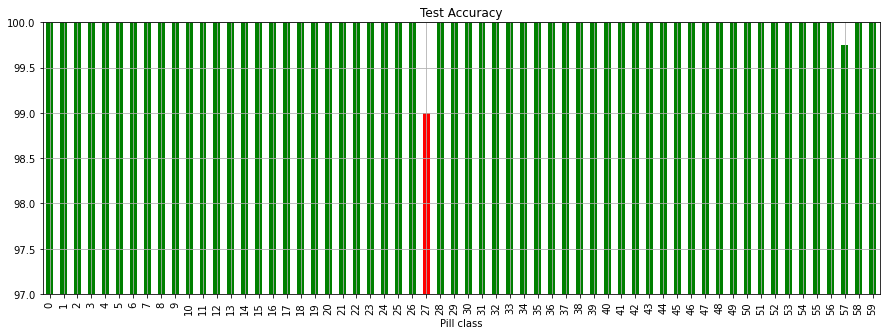

In [40]:
from datetime import datetime
test_acc=li/int(nb_samples/classes)*100
res_test = pd.DataFrame({"Pill class": [e for e in range(classes)],"Accuracy": test_acc})
a=res_test.plot.bar(grid=True, x = "Pill class", y = "Accuracy", ylim=(97,100), legend=None, color=np.where(res_test["Accuracy"]>99.5, 'g', 'r')) # 플로팅.

plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Test Accuracy")

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H:%M:%S, from EB0")

file_name = dt_string+'_test_plotting_best.png'
plt.savefig(file_name)

In [41]:
res_test

,Pill class,Accuracy
0,0,100.00
1,1,100.00
2,2,100.00
3,3,100.00
4,4,100.00
5,5,100.00
6,6,100.00
7,7,100.00
8,8,100.00
9,9,100.00


6. Sample 1장에 대해 test (best)

In [42]:
import cv2
sample_dir = './sample.jpg'
img = cv2.imread(sample_dir)
img = cv2.resize(img, (224,224))
img = np.expand_dims(img, axis=0)
input_data = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

predict = best_model.predict(input_data)

print('Pill Class :', argmax(predict), '     Percentage :', 100*max(predict[0]))

Pill Class : 2      Percentage : 100.0


7. 모델 저장

In [43]:
# new_model.save('last_model_EB0.h5') #케라스 모델로 저장. # 이미 콜백으로 best_model.h5로 저장됨
# 현재 쓸모없음.
# new_model.save('last_model_EB0_pb')# 저장되도 이 .pb 파일을 바로 dnn으로 돌릴 수 없고 아래처럼 frozen_graph.pb로 변환해야 함.
# 현재 쓸모없음.

8-1. tflite를 위한 h5 파일 변환

In [44]:
# Converting a tf.Keras model to a TensorFlow Lite model.

# load best model
best_model = tf.keras.models.load_model('./best_model_EB0_pb')
#last_model = tf.keras.models.load_model('./last_model_EB0_pb')

# converter = tf.lite.TFLiteConverter.from_saved_model() # only take .pb?
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
open("converted_model_EB0.tflite", "wb").write(tflite_model)

# 양자화 해보기
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("converted_model_quart_EB0.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp62touiof/assets
INFO:tensorflow:Assets written to: /tmp/tmpw3pjj5en/assets


INFO:tensorflow:Assets written to: /tmp/tmpw3pjj5en/assets


80314060

8-2. opencv-dnn 모듈을 위한 frozen_graph.pb, .pbtxt 로 변환

참고
https://medium.com/@sebastingarcaacosta/how-to-export-a-tensorflow-2-x-keras-model-to-a-frozen-and-optimized-graph-39740846d9eb

In [45]:
# Full code to freeze your Keras model and save it
# 그냥 포맷 변환이라고 생각 opencv 에서 쓰기 위해.

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
#path of the directory where you want to save your model
frozen_out_path = ''
# name of the .pb file
frozen_graph_filename = "frozen_graph_EB0_for_dnn"
# my model to change
#model = new_model --> lastmodel
model = tf.keras.models.load_model('./best_model_EB0_pb')

print('model',model)
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
print('full_model1', full_model)
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
print('full_model2', full_model)
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)



model <tensorflow.python.keras.engine.functional.Functional object at 0x7f42c8d16ed0>
full_model1 <tensorflow.python.eager.def_function.Function object at 0x7f43bb480910>
full_model2 ConcreteFunction <lambda>(x)
  Args:
    x: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    float32 Tensor, shape=(None, 60)
------------------------------------------------------------
Frozen model layers: 
x
model/stem_conv/Conv2D/ReadVariableOp/resource
model/stem_conv/Conv2D/ReadVariableOp
model/stem_conv/Conv2D
model/stem_bn/ReadVariableOp/resource
model/stem_bn/ReadVariableOp
model/stem_bn/ReadVariableOp_1/resource
model/stem_bn/ReadVariableOp_1
model/stem_bn/FusedBatchNormV3/ReadVariableOp/resource
model/stem_bn/FusedBatchNormV3/ReadVariableOp
model/stem_bn/FusedBatchNormV3/ReadVariableOp_1/resource
model/stem_bn/FusedBatchNormV3/ReadVariableOp_1
model/stem_bn/FusedBatchNormV3
model/stem_activation/Sigmoid
model/stem_activation/mul
model/block1a_dwconv/depthwise/ReadVariableOp/resource
mode

'frozen_graph_EB0_for_dnn.pbtxt'

In [46]:
## __version 1__ ##